# Loading the libraries

In [ ]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sb
from gprofiler import gprofiler
import re
import loompy

%pylab inline
#import sys

import rpy2.rinterface_lib.callbacks
import logging
import anndata2ri
from rpy2.robjects import pandas2ri

import warnings
from rpy2.rinterface import RRuntimeWarning
# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [ ]:
import warnings
warnings.filterwarnings(action='once')

In [ ]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

In [ ]:
import scvelo as scv
scv.settings.set_figure_params(frameon = True, style='scvelo')
sc.settings.verbosity = 0

In [ ]:
rcParams['pdf.fonttype'] = 'truetype'
sc.set_figure_params(vector_friendly=True,dpi_save=300,transparent=True)
pl.rcParams['lines.linewidth'] = 0.1
sc.set_figure_params(color_map='viridis')
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [ ]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle3)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(Matrix)
library(DropletUtils)
library(cowplot)
library(dplyr)
library(GSVA)
library(GSEABase)
library(Seurat)
library(reticulate)

# Setup working dir

In [ ]:
import os
os.chdir('/Volumes/LaCie/Andres/TDS_exp1/TDS60/results')
if not os.path.exists('./figures'):
    os.makedirs('./figures')

#/Users/afvp1f17/Documents/00-Transcriptomics/00-SC-RNA-Seq/Becky/kallisto
#/Users/afvp1f17/Documents/00-Transcriptomics/00-SC-RNA-Seq/DC2/kallisto   
#'/Users/afvp1f17/Documents/00-Transcriptomics/00-SC-RNA-Seq/DC/PBMC'
#/Users/afvp1f17/Documents/00-Transcriptomics/00-SC-RNA-Seq/DC/DC_CTR_Run2 
#/Users/afvp1f17/Documents/00-Transcriptomics/00-SC-RNA-Seq/10X_PBMC_10k/filtered_feature_bc_matrix

# Load in the data

## Load from h5ad

In [163]:
adata = sc.read('standard/kallistobus_prefiltered_data.h5ad', cache=False)
adata.obs['sample'] = ['CDS']*adata.n_obs
adata.X = sp.sparse.csr_matrix(adata.X)

In [137]:
#sc.pp.subsample(adata, n_obs=7000, random_state=0, copy=False)

In [164]:
print(adata.obs['sample'].value_counts())

CDS    3784
Name: sample, dtype: int64


In [102]:
adata=sc.pp.downsample_counts(adata, counts_per_cell=296,random_state=0, copy=True)

In [90]:
adata1 = sc.read('standard/kallistobus_prefiltered_data.h5ad', cache=False)
adata1.obs['sample'] = ['10X']*adata1.n_obs
adata1.X = sp.sparse.csr_matrix(adata1.X)

In [ ]:
adata1=sc.pp.downsample_counts(adata1, counts_per_cell=700,random_state=0, copy=True)

In [ ]:
print(adata1.obs['sample'].value_counts())

In [ ]:
adata= adata.concatenate(adata1, batch_key='LPS')
adata.var_names_make_unique() 

In [ ]:
print(adata.obs['sample'].value_counts())


#  QC

In [165]:
pl.rcParams['figure.figsize']=(4,4) #rescale figures

In [166]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['mt_frac'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata

#mt_gene_mask = [gene.startswith('MT-') for gene in adata.var['gene_symbol']]
#adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

AnnData object with n_obs × n_vars = 3784 × 7845 
    obs: 'n_counts', 'n_genes', 'log_counts', 'mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'sample', 'mt_frac'
    var: 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'sample' as categorical


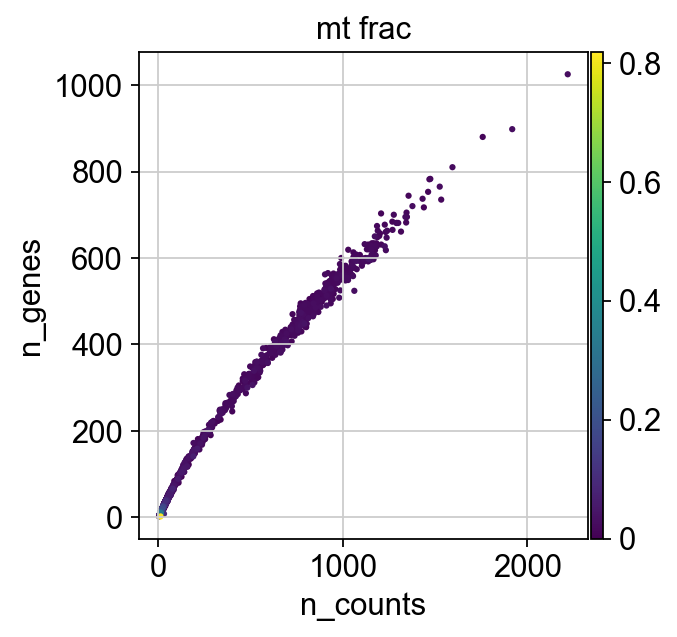

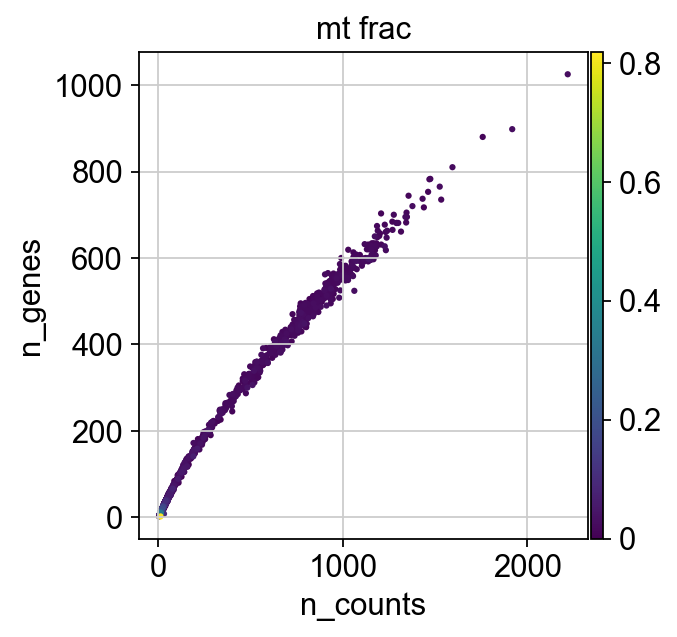

In [167]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

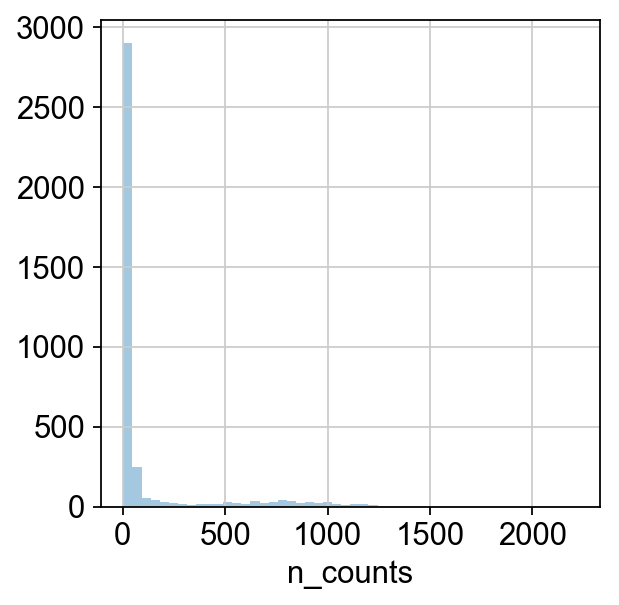

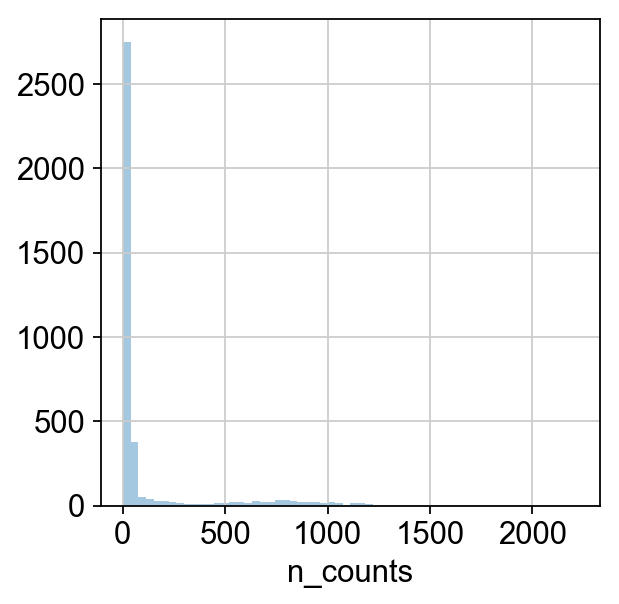

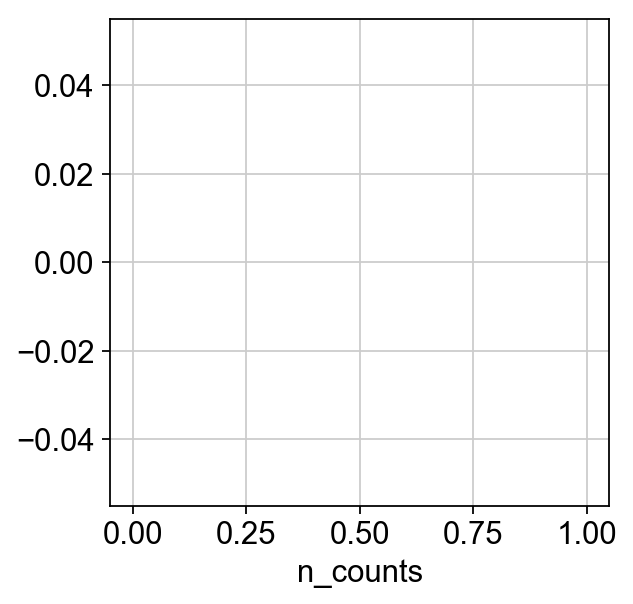

In [168]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
pl.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
pl.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
pl.show()

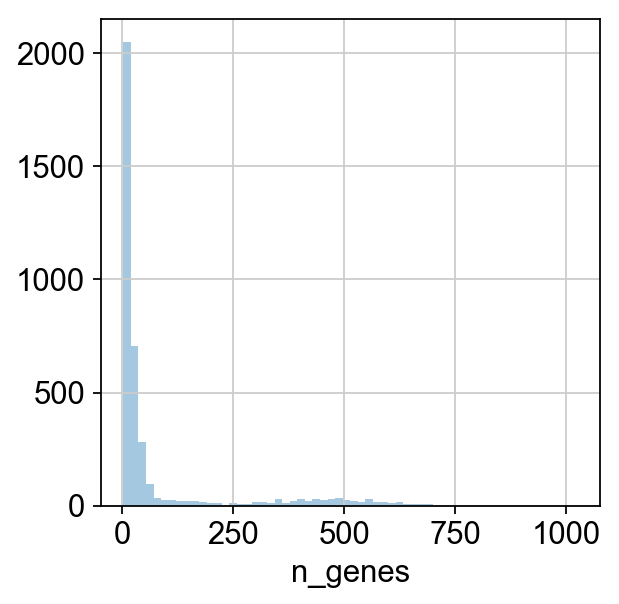

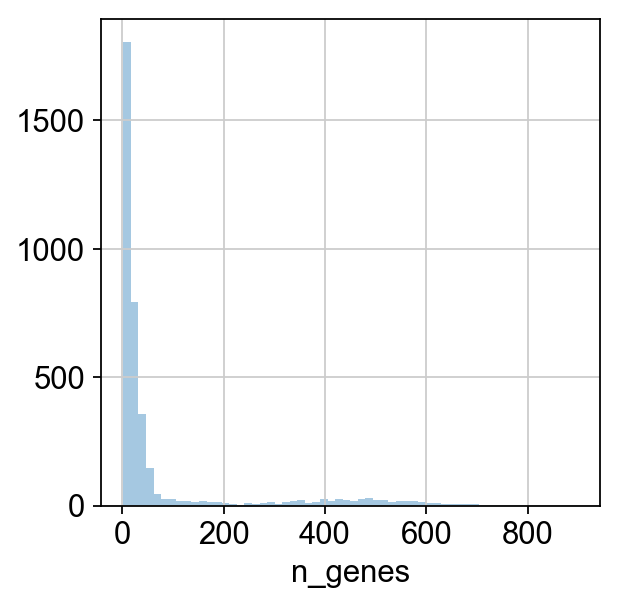

In [169]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
pl.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
pl.show()


## detecting true cells 

In [ ]:
#data_mat = adata.X.T

In [ ]:
%%R -i data_mat 
set.seed(100)
Reads <- data_mat

e.out <- emptyDrops(Reads)
is.cell <- e.out$FDR <= 0.01


#plot(e.out$Total, -e.out$LogProb, col=ifelse(is.cell, "red", "black"),xlab="Total UMI count", ylab="-Log Probability")

sum(is.cell, na.rm=TRUE)

In [ ]:
%%R
plot(e.out$Total, -e.out$LogProb, col=ifelse(is.cell, "red", "black"),xlab="Total UMI count", ylab="-Log Probability")

In [ ]:
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))

expected_num_cells=7848

ax.loglog(knee, range(len(knee)), label="kallisto", linewidth=5, color="k")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="g")
ax.axhline(y=expected_num_cells, linewidth=3, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
ax.legend()
plt.show()

# Filtering cells and genes

The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset.

In [172]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 10000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 5)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Trying to set attribute `.obs` of view, making a copy.


Total number of cells: 480
Number of cells after min count filter: 420
Number of cells after max count filter: 420
Number of cells after MT filter: 420
Number of cells after gene filter: 420


In [173]:
print(adata.obs['sample'].value_counts())

CDS    420
Name: sample, dtype: int64


In [174]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 7845
Number of genes after cell filter: 6901


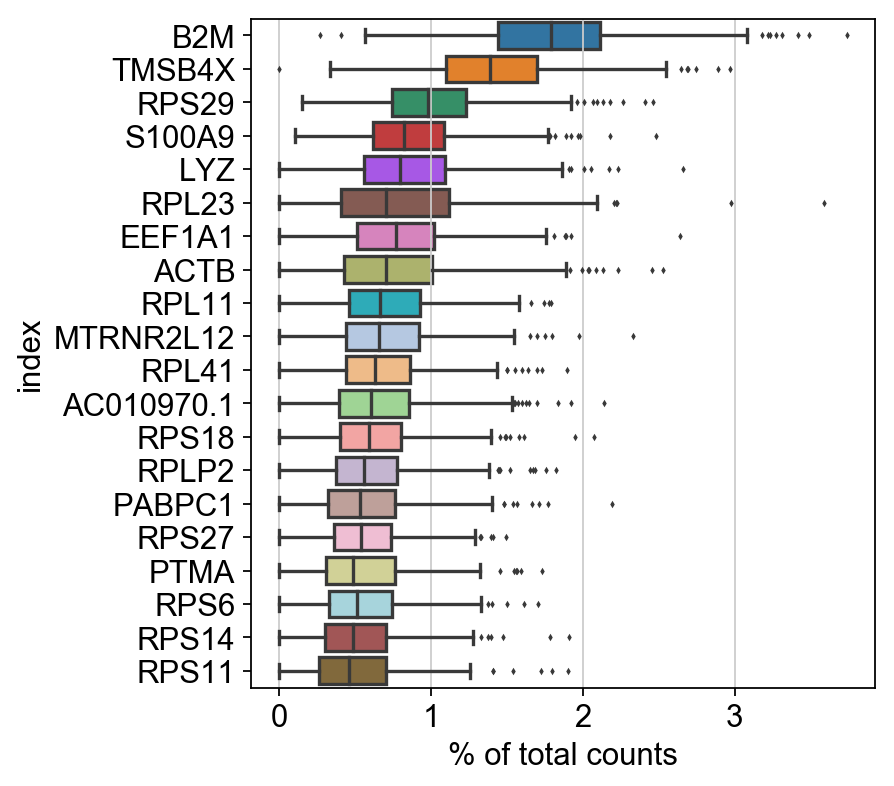

In [175]:
sc.pl.highest_expr_genes(adata, n_top=20,save='.pdf')

In [176]:
# label mitochondtial genes
regex = re.compile('^(MT).*', re.IGNORECASE)
mito_genes = [l for l in adata.var_names for m in [regex.search(l)] if m]
adata.var['mito'] = False
adata.var.loc[mito_genes, 'mito'] = True
print('Found {} mito genes and annotated.'.format(len(mito_genes)))

Found 65 mito genes and annotated.


In [177]:
# compute qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=True)
adata.obs.head()

,n_counts,n_genes,log_counts,mito,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,sample,mt_frac
index,,,,,,,,,,,,,,,,,
AAAAACGGCTTG,606.0,383,6.406880,0.014851,378,5.937536,601.0,6.400258,32.445923,49.084859,70.382696,100.000000,12.0,2.564949,1.996672,CDS,0.014851
AAAACTGCAGAC,625.0,388,6.437752,0.011200,382,5.948035,619.0,6.429719,32.956381,50.080775,70.597738,100.000000,17.0,2.890372,2.746365,CDS,0.011200
AAAATCGCAAAT,842.0,493,6.735780,0.015439,488,6.192362,837.0,6.731018,30.346476,45.639188,65.591398,100.000000,27.0,3.332205,3.225806,CDS,0.015439
AAACCAGCGGCG,919.0,565,6.823286,0.017410,557,6.324359,910.0,6.814543,28.131868,41.208791,60.769231,93.736264,25.0,3.258096,2.747253,CDS,0.017410
AAAGGAGGGAAT,1167.0,634,7.062191,0.012853,626,6.440947,1159.0,7.056175,31.147541,44.434858,61.691113,89.128559,28.0,3.367296,2.415876,CDS,0.012853


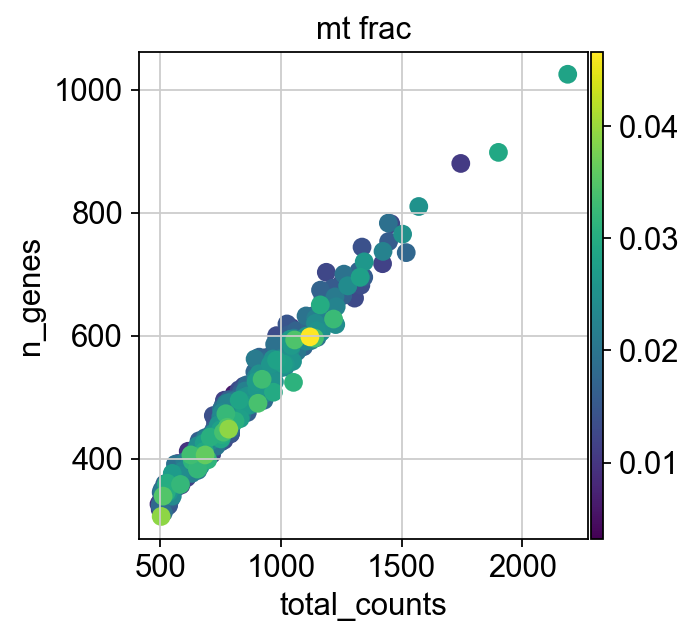

In [178]:
# plot percentage of mitochondtial genes versus count depth and n_genes
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='mt_frac',save='.pdf')

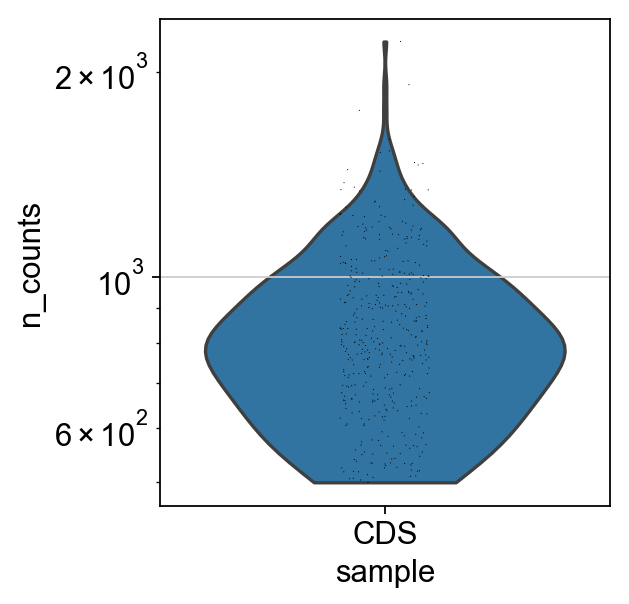

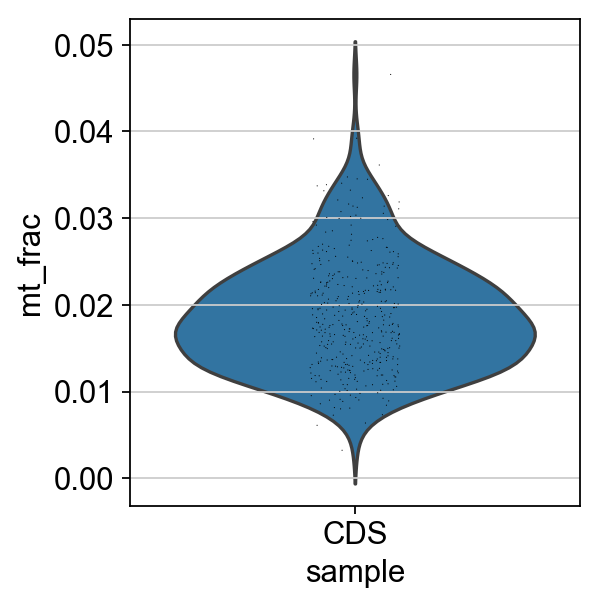

In [179]:
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=0.5, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample',size=0.5)

In [180]:
print(adata.obs['sample'].value_counts())

CDS    420
Name: sample, dtype: int64


In [181]:
adata.obs['n_counts'].sum()/adata.obs['sample'].value_counts()

CDS    859.480952
Name: sample, dtype: float64

In [117]:
results_file = './_raw_data.h5ad' 
adata.write('./_filtered_merged_CTR_LPS.h5ad')

## change the sequencing depth (subsample )

In [153]:
adata=sc.pp.downsample_counts(adata, counts_per_cell=300,random_state=0, copy=True)

In [154]:
adata.X = sp.sparse.csr_matrix(adata.X)

In [155]:
adata.var_names_make_unique() 

## plot binomial model

In [38]:
markers = ['RPL12','CCR7','CXCL3','CD3D','CXCL8','IL1B','IRF7','SOD2','SP110','IFIH1','LAIR1','JUNB','NR2C2','BATF','LILRB4','SELPLG','LY9','NRP1','CRLF2','CD93','TNFRSF10B','CD164','CD226','ATP1B3','CD81','ICAM1','TLR10','TFRC','CDH1','CD3E','CFL1','GAPDH','COX7C','RPS5','CD4','CD8A','CD56','FCGR3A','CD19','ITGAX','CD14','PTPRC','CD34','HLA-DRA','LIMA1','DENND1B','IDO1','C1ORF54','CLEC9A','XCR1','CD1C','FCER1A','CLEC10A','FCGR2B','S100A9','S100A8','RNASE2','F13A1','TESC','TMEM176B','LOC200772','CD5','AXL','SIGLEC6','CD22','GZMB','IGJ','SERPINF1','DERL3','CLEC4C','CYP1B1','VCAN','FCGR1A','LAIR2','XYLT1','LIPA','TCF7L2','CXCR1','CXCR2','CSF3R','MMP25','ALPL','CCL4','GNLY','IL32','PRF1','GZMH','CD96','IL2RB','KLRB1','FGFBP2','IL10','IL12','IL15','IL13','IL26','IL31','IL9','IL22','IL4','CD40','CD70','CD80','CD83','CD206','CD208','CD205','CD209','PDL1','TNFA','B2M','CTSS','ITGAV','NCF2','PDIA3','PSMA1','PSMD10','PSMD2','TAP1','TAP2','SLA2','NLRC3','CCL5','ETS1','LCK','CBLB','ERAP1','IFNG']
len(markers)

128

In [156]:
markers = ["LDHB","IL7R","S100A9","CD80","LYZ","CD79A","MS4A1","CCL5","GZMK","FCGR3A","LST1","GZMB","PRF1","FCER1A","CLEC10A","UBB","CFL1","HLA-E","RPL10","CD40","NFKB2","PSME1","STAT3","SQSTM1","NFKB1","SOCS5","IRF4","SOCS1","SOCS3","SOCS6","IDO1","MYC","CCL22","IL10RA","CD70","IRF1","CYBB","CD207","CD1A","HLA-DRB1","CD74","CD86","CD274","LYN","MALT1","BIRC2","HLA-DQA1","HLA-DPA1","NFKBIZ","MLANA","TYRP1","IGFBP7"]
len(markers)

52

In [157]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [158]:
markers1=(intersection(markers, adata.var.index))
len(markers1)

48

In [159]:
mean_ = np.array(adata.X.mean(0))
var_ = np.array(adata.X.power(2).mean(0) - mean_ ** 2)
frac_zero = np.array( (adata.X > 0).sum(0) / adata.shape[0])
adata.var['mean_'] = mean_[0]
adata.var['var_'] = var_[0]
adata.var['frac_zero'] = frac_zero[0]

In [160]:
selected = adata[:, adata.var_names.isin(markers1)]  

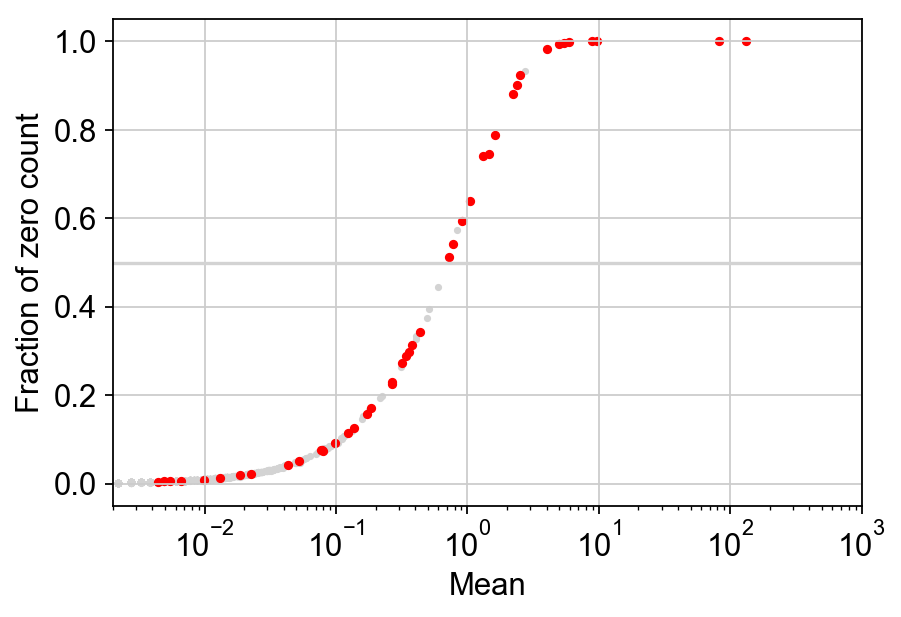

In [161]:
figsize(6, 4)
pl.xscale('log')
pl.scatter(adata.var['mean_'], adata.var['frac_zero'],s=5, c='lightgrey', label='Observed RNA', rasterized=True)
pl.scatter(selected.var['mean_'], selected.var['frac_zero'],s=10, c='r', label='Observed RNA', rasterized=True)
pl.xlim(left=2e-3, right=1e3)
pl.ylim(-0.05, 1.05)
pl.xlabel('Mean')

pl.axhline(y=0.5, color='lightgrey', linestyle='-')
pl.ylabel('Fraction of zero count');
pl.savefig('Fraction_of_expressing_cells_Rhapsofy.pdf')

In [162]:
(selected.var['frac_zero']>0.5).sum(0)

18

In [ ]:
from scipy import optimize
var_fun = lambda mu, phi: mu + phi * mu ** 2


phi_hat, _ = optimize.curve_fit(var_fun, adata.var['mean_'], adata.var['var_'])
adata.uns['phi_hat'] = phi_hat

In [ ]:
xx = np.logspace(-4, 4, num=128)

def prob_zero_fun(mu, phi):
    if phi == .0:
        return np.exp(-mu)
    
    phi_1 = 1. / phi
    return (phi_1 / (mu + phi_1)) ** phi_1

In [ ]:
%pylab inline
import pandas as pd
import anndata

In [ ]:
figsize(6, 4)
plt.loglog()

for phi in [0., 0.5, 1.0, 2.0, 4.0]:
    c = 'r'
    label = f'NB ($ \phi $ = {phi})'
    alpha = 1.5 / (1. + phi)
    if phi == 0:
        c = 'k'
        label = 'Poisson'
        alpha = 1.0

    yy = var_fun(xx, phi)
    plt.plot(xx, yy, c=c, label=label, alpha=alpha)
    
plt.xlim(left=2e-4, right=1e4)
plt.ylim(bottom=1e-4, top=2e6);
plt.legend();

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Mean')
plt.ylabel('Variance');

plt.savefig('NB_variance_theory.pdf')

In [ ]:
figsize(6, 4)
plt.xscale('log')

for phi in [0., 0.5, 1.0, 2.0, 4.0]:
    c = 'r'
    label = f'NB ($ \phi $ = {phi})'
    alpha = 1.5 / (1. + phi)
    if phi == 0:
        c = 'k'
        label = 'Poisson'
        alpha = 1.0

    yy = prob_zero_fun(xx, phi)
    plt.plot(xx, yy, c=c, label=label, alpha=alpha)
    
plt.xlim(left=2e-4, right=1e4)
plt.legend();

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Mean')
plt.ylabel('Probability of zero count');

plt.savefig('NB_zeros_theory.pdf')

In [ ]:
figsize(6, 4)
yy = 1-prob_zero_fun(xx, adata.uns['phi_hat'])
plt.xscale('log')
plt.scatter(adata.var['mean_'], adata.var['frac_zero'], c='k', label='Observed RNA', rasterized=True)
plt.plot(xx, yy, lw=3, c='w')
plt.plot(xx, yy, lw=1, c='r', label='NB zeros')
plt.xlim(left=2e-4, right=1e4)
plt.xlabel('Mean')
plt.ylabel('Probability of zero count');
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(scatterpoints=3)
    
adata.uns['zero_corr'] = \
prob_zero_fun(adata.var['mean_'], adata.uns['phi_hat']) \
.corr(adata.var['frac_zero'], method='spearman')
    
    
plt.tight_layout()
plt.savefig('mean_zeros.pdf', dpi=300)

In [ ]:
adata=selected.copy()

In [ ]:
ax = sc.pl.stacked_violin(adata, markers1, groupby='sample',save='.pdf')

## select genes present in the panel 

In [ ]:
markers = ['RPL12','CCR7','LYZ','CXCL3','CD3D','CXCL8','IL1B','IRF7','SOD2','SP110','IFIH1','LAIR1','JUNB','NR2C2','BATF','LILRB4','SELPLG','LY9','NRP1','CRLF2','CD93','TNFRSF10B','CD164','CD226','ATP1B3','CD81','ICAM1','TLR10','TFRC','CDH1','CD3E','CFL1','GAPDH','COX7C','RPS5','CD4','CD8A','CD56','FCGR3A','CD19','ITGAX','CD14','PTPRC','CD34','HLA-DRA','LIMA1','DENND1B','IDO1','C1ORF54','CLEC9A','XCR1','CD1C','FCER1A','CLEC10A','FCGR2B','S100A9','S100A8','RNASE2','F13A1','TESC','TMEM176B','LOC200772','CD5','AXL','SIGLEC6','CD22','GZMB','IGJ','SERPINF1','DERL3','CLEC4C','CYP1B1','VCAN','FCGR1A','LAIR2','XYLT1','LIPA','TCF7L2','CXCR1','CXCR2','CSF3R','MMP25','ALPL','CCL4','GNLY','IL32','PRF1','GZMH','CD96','IL2RB','KLRB1','FGFBP2','IL10','IL12','IL15','IL13','IL26','IL31','IL9','IL22','IL4','CD40','CD70','CD80','CD83','CD206','CD208','CD205','CD209','PDL1','TNFA','B2M','CTSS','ITGAV','NCF2','PDIA3','PSMA1','PSMD10','PSMD2','TAP1','TAP2','SLA2','NLRC3','CCL5','ETS1','LCK','CBLB','ERAP1','IFNG']
len(markers)

In [ ]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [ ]:
markers1=(intersection(markers, adata.var.index))
len(markers1)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='sample')

In [ ]:
sc.tl.rank_genes_groups(adata, 'sample', groups=['C10X'], reference='10X', method='t-test')

In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pl.rank_genes_groups(adata)

In [ ]:
pl.rcParams['lines.linewidth'] = 0.1
sc.pl.rank_genes_groups_violin(adata,jitter=0,size=0, gene_names=['IL1B','CXCL8','CXCL3','CCR7','JUNB','CD164','CD81','PTPRC','IRF7','CD164','ICAM1','CD8A','CD14','FCER1A'],save='1B.pdf')

In [ ]:
pl.rcParams['lines.linewidth'] = 0.1
sc.pl.rank_genes_groups_violin(adata,jitter=0,size=0, gene_names=['S100A9','RPL12','LYZ','COX7C','CFL1','GAPDH','JUNB','PTPRC','IL1B','CD14','IRF7','CD164','PTPRC','FCGR3A','CXCL8'],save='1B.pdf')

In [ ]:
selected = adata[:, adata.var_names.isin(markers1)] 
selected=selected.copy()
selected.shape

In [ ]:
selected=selected.copy()

In [ ]:
adata=selected
adata.shape

# Normalization

## Scran Normalization

In [ ]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

In [ ]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [ ]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [ ]:
#Delete adata_pp
del adata_pp

In [ ]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

In [ ]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [ ]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
adata.X = sp.sparse.csr_matrix(adata.X)
sc.pp.log1p(adata)

In [ ]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## CPTT normalization 

In [ ]:
#Normalize adata 
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# Export Normalized matrix

In [ ]:
adatat=adata.T

In [ ]:
adatat.write_csvs('adata', skip_data=False)

In [ ]:
%%R
data <- read.csv("adata/X.csv",header = F)
Rnames <- read.csv("adata/obs.csv",header = T)
dim(Rnames)
Rnames <- Rnames[,1]
head(Rnames)

Cnames1 <- read.csv("adata/var.csv")

Cnames <- Cnames1[,1]

colnames(data) <- Cnames
row.names(data) <- Rnames
write.table(data, "Filtered_alldata_kallisto_CTR.txt", sep="\t")
data <- as.matrix(data)
colnames(data) <- paste0("A_", 1:ncol(data))

# Overlay gene signature on UMAP using Scanpy Scoring

In [ ]:
## Overlay gene signature on UMAP using Scanpy Scoring
from matplotlib import colors
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

folder = "/home/agando/Documents/Meshal/PhD_Scripts/short_scripts/Bleo_highRes/Epithel/"
gene_list = pd.read_csv(folder + "Data/Broad_hallmark_gene_sets_2.txt", sep = "\t")

In [ ]:
pathways = ["HALLMARK_OXIDATIVE_PHOSPHORYLATION", "HALLMARK_TNFA_SIGNALING_VIA_NFKB",
            "HALLMARK_MYC_TARGETS_V1", "HALLMARK_P53_PATHWAY", "HALLMARK_HYPOXIA"]
for pathway in pathways:
    genes = gene_list.loc[:, pathway].values
    genes = [g.capitalize() for g in genes]
    genes = np.intersect1d(genes, adata.var_names)
    s_name = pathway.replace("HALLMARK_", "")
    sc.tl.score_genes(adata, gene_list = genes, score_name = s_name)
    sc.pl.umap(adata, color = s_name, ax = plt.figure(figsize = (6, 5), dpi = 110).gca(),
              legend_loc = "on data", cmap = mymap, vmin = 0, size = 20)

# GSVA

In [ ]:
%%R
DCtypes.gmt<- getGmt("/Users/afvp1f17/Documents/00-Transcriptomics/Broad_anotation/Science_paper2.gmt", geneIdType=SymbolIdentifier())
Clases.gmt <- geneIds(DCtypes.gmt)

In [ ]:
%%R -o GSVA_res
GSVA_res <- gsva(data, #your data
                      Clases.gmt, # your gene set collection
                      min.sz=1, max.sz=2000, #criteria for filtering gene sets
                      verbose=FALSE,
                      mx.diff=FALSE,
                      method="gsva")
write.csv(GSVA_res,"GSVA_res.csv")

In [ ]:
GSVA_res = pd.read_csv('./GSVA_res.csv', header=0,index_col=0, sep=',')

In [ ]:
sb.clustermap(GSVA_res, metric="euclidean", method="ward", cmap="Blues", standard_scale=1)

In [ ]:
%%R
DCtypes.gmt<- getGmt("/Users/afvp1f17/Documents/00-Transcriptomics/Broad_anotation/Science_paper3.gmt", geneIdType=SymbolIdentifier())
Clases.gmt <- geneIds(DCtypes.gmt)

In [ ]:
%%R -o GSVA_res
GSVA_res <- gsva(data, #your data
                      Clases.gmt, # your gene set collection
                      min.sz=1, max.sz=2000, #criteria for filtering gene sets
                      verbose=FALSE,
                      mx.diff=FALSE,
                      method="gsva")
write.csv(GSVA_res,"GSVA_res.csv")

In [ ]:
GSVA_res = pd.read_csv('./GSVA_res.csv', header=0,index_col=0, sep=',')

metricstr or function, optional
The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

 methods 'single' ‘complete’, ‘average’, ‘weighted’ and ‘ward’ 

In [ ]:
sb.clustermap(GSVA_res, metric="euclidean", method="ward", cmap="Blues", standard_scale=1)

In [ ]:
sb.clustermap(GSVA_res, metric="euclidean", method="ward", cmap="Blues", z_score=1)

In [ ]:
cmap = sb.diverging_palette(220, 10, as_cmap=True)
sb.heatmap(GSVA_res, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Batch correection

In [ ]:
# ComBat batch correction
sc.pp.combat(adata, key='sample')

# Feature selection Highly Variable Genes

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.00, max_mean=4, min_disp=0.1)



In [ ]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=60,batch_key='sample')
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

In [ ]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

In [ ]:
pl.rcParams['lines.linewidth'] = 0.1
sc.pl.highly_variable_genes(adata,save='.pdf')


##  Filter highly variable genes

In [ ]:
# Comptue PCA representation
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# Look at variance distribution
sc.pl.pca_variance_ratio(adata)

In [ ]:
# set a number of pc's to be used in downstream analysis
n_pcs =30

In [ ]:
# Look at quality metrics in the PCA plot
sc.pl.pca(adata, color=['FCGR3A'])

In [ ]:
# Check the loadings
sc.pl.pca_loadings(adata)

In [ ]:
# compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=n_pcs, random_state=42)

In [ ]:
# Calculate the visualizations
sc.tl.umap(adata,random_state=42)
sc.tl.diffmap(adata,n_comps=10)
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.pca_scatter(adata, color='n_counts',save='.pdf')
sc.pl.umap(adata, color=['FCGR3A'],save='.pdf')
sc.pl.diffmap(adata, color=['n_counts','FCGR3A'], components=['1,2','1,3'],save='.pdf')
sc.pl.draw_graph(adata, color='n_counts',save='.pdf')

In [ ]:
#sc.tl.tsne(adata, n_jobs=8) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
#sc.pl.tsne(adata, color='n_counts',save='.pdf')

# Clustering

In [ ]:
# Perform clustering - using highly variable genes
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5',random_state=42)

In [ ]:
adata.obs['leiden_r0.5'].value_counts()

In [ ]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['leiden_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['leiden_r0.5','log_counts', 'mt_frac'],size=1,save='1.pdf')


In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','LYZ'], palette=sc.pl.palettes.default_64, legend_loc='on data',save='1_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','FCER1A'], palette=sc.pl.palettes.default_64,color_map=mymap, legend_loc='on data',save='2_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','FCGR3A'], palette=sc.pl.palettes.default_64, color_map=mymap,legend_loc='on data',save='3_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','ICAM1'], palette=sc.pl.palettes.default_64,color_map=mymap, legend_loc='on data',save='4_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','FCER1A'], palette=sc.pl.palettes.default_64,color_map=mymap, legend_loc='on data',save='5_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','HLA-DRA'], palette=sc.pl.palettes.default_64,color_map=mymap, legend_loc='on data',save='6_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','CXCL8'], palette=sc.pl.palettes.default_64,color_map=mymap, legend_loc='on data',save='7_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','sample'], palette=sc.pl.palettes.default_64,color_map=mymap, legend_loc='on data',save='7_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','PTPRC'], palette=sc.pl.palettes.default_64,color_map=mymap, legend_loc='on data',save='8_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','IL1B'], palette=sc.pl.palettes.default_64,color_map=mymap, legend_loc='on data',save='9_ondata.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','S100A9'], palette=sc.pl.palettes.default_64,color_map=mymap, legend_loc='on data',save='10_ondata.pdf')

In [ ]:
sc.pl.diffmap(adata, color=['FCGR3A','HLA-DRA'], components=['1,2'], color_map=mymap,save='7.pdf',legend_loc='on data')

In [ ]:
sc.pl.draw_graph(adata, color=['FCGR3A','HLA-DRA'],color_map=mymap,save='8.pdf')

In [ ]:
sc.tl.leiden(adata, resolution=0.2, restrict_to=('leiden_r0.5', ['2']))

In [ ]:
sc.pl.umap(adata, color=['leiden'], palette=sc.pl.palettes.default_64)

# Choose colors for UMAP

In [ ]:
type_palette = ["#d62728", '#1f77b4', '#faa95a', '#98df8a', "#0aa65d", '#9467bd', '#c7c7c7', 
                '#c49c94', '#e377c2', '#8c564b', '#bcbd22', '#aec7e8', '#17becf']
sc.pl.umap(adata, color = "cell_type_recombined", ax = plt.figure(figsize = (6, 5), dpi = 110).gca(),
           palette = type_palette)

## Plot sample density 

In [ ]:
sc.tl.embedding_density(adata, basis='umap', groupby='sample')

In [ ]:
adata.obs['sample'].value_counts()
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='CTR',save='1.pdf')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='LPS',save='2.pdf')

In [ ]:

sc.pl.diffmap(adata, components='1,2', color='leiden_r0.5')

sc.pl.diffmap(adata, components='1,3', color='leiden_r0.5')

# Marker genes & cluster annotation

## calculate marker genes using ttest

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5')

In [ ]:
pl.rcParams['figure.figsize']=(4,4) #rescale figures
sc.set_figure_params(dpi=100, dpi_save=300)

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5')

In [ ]:
markers=pd.DataFrame(adata.uns['rank_genes_r0.5']['names']).head(25)
markers

In [ ]:
markers.to_csv('figures/Marker_genes_ttest_dc2.csv')

## calculate marker genes using logreg

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5',method='logreg')

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5',save='_logreg.pdf')

In [ ]:
markers=pd.DataFrame(adata.uns['rank_genes_r0.5']['names']).head(15)
markers

In [ ]:
markers.to_csv('figures/Marker_genes_logreg.csv')

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['1','0'], fontsize=12)
#sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['2','1'], fontsize=12)
#sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['4','5'], fontsize=12)

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups_matrixplot(adata, key='rank_genes_r0.5',n_genes=3,swap_axes=False,cmap='bwr',var_group_rotation=90,save='.pdf')

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups_tracksplot(adata, key='rank_genes_r0.5',n_genes=3,save='.pdf')



In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups_matrixplot(adata, key='rank_genes_r0.5',n_genes=3,save='.pdf')



In [ ]:
ax = sc.pl.dendrogram(adata, 'leiden_r0.5')

In [ ]:

# compute hiearchical clustering based on the
# given `var_names` from the raw matrix
sc.tl.dendrogram(adata, 'leiden_r0.5', n_pcs=30)

In [ ]:
ax = sc.pl.rank_genes_groups_matrixplot(adata, key='rank_genes_r0.5')

In [ ]:
sc.pl.umap(adata, color=['HLA-DRA','ITGAX'])

In [ ]:
#HLA-DRA
sc.pl.umap(adata, color='HLA-DRA', use_raw=False,color_map=mymap)


In [ ]:
#HLA-DRA
sc.pl.umap(adata, color='HLA-DRA', use_raw=False)
sc.pl.umap(adata, color='PRF1', use_raw=False)
sc.pl.umap(adata, color='n_counts', use_raw=False)



In [ ]:
sc.pl.umap(adata, color=['IRF7','IRF1','IDO1','PRF1'],save='PRF1.pfd')

In [ ]:
sc.pl.umap(adata, color=['FOS', 'JUND','CD74','MLANA'])

In [ ]:
sc.pl.umap(adata, color=['JUND','FOS','HLA-DRA','AL671277.1'])

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','IDO1'])

## compute qc metrics per cluster

In [ ]:
# compute qc metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.obs.head()

In [ ]:

g=sb.catplot(x="leiden_r0.5", y="n_genes",kind="boxen", data=adata.obs)
g.set_xticklabels(rotation=0)

In [ ]:

g=sb.catplot(x="leiden_r0.5", y="log1p_total_counts", kind="boxen",data=adata.obs)
g.set_xticklabels(rotation=0)
g.savefig("output.png")

In [ ]:
g.savefig("figures/QC_plot_logcounts.pdf")

In [ ]:

g=sb.catplot(x="leiden_r0.5", y="n_counts", kind="boxen",data=adata.obs)
g.set_xticklabels(rotation=90)

In [ ]:
g.savefig("figures/QC_plot_n_counts.pdf")

In [ ]:

g=sb.catplot(x="leiden_r0.5", y="n_genes", kind="boxen",data=adata.obs)
g.set_xticklabels(rotation=90)

In [ ]:
g.savefig("figures/QC_plot_n_genes.pdf")

# Marker enrichment 

marker genes for PBMC

 Markers | Cell Type
---|---
 IL7R | CD4 T cells
CD14, LYZ | CD14+ Monocytes
MS4A1 |	B cells
CD8A |	CD8 T cells
GNLY, NKG7 | 	NK cells
FCGR3A, MS4A7 |	FCGR3A+ Monocytes
FCER1A, CST3 |	Dendritic Cells
PPBP |	Megakaryocytes

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5')

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5',method='logreg')

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden', key_added='rank_genes_r0.5')

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden', key_added='rank_genes_r0.5',method='logreg')

## PBMC markers

In [ ]:
#Known marker genes:
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5')
marker_genes = dict()
marker_genes['CD4_T_cells'] = [ 'IL7R' ]
marker_genes['CD14_Mono'] = [ 'CD14', 'LYZ']
marker_genes['B_cells'] = [ 'MS4A1']
marker_genes['CD8_T_cells'] = [ 'CD8A']
marker_genes['NK_cells'] = [ 'GNLY', 'NKG7']
marker_genes['FCGR3A_Monocytes'] = [ 'FCGR3A', 'MS4A7']
marker_genes['Dendritic'] = [ 'FCER1A', 'CST3']
marker_genes['Megakaryocytes'] = [ 'PPBP']


In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5')
cell_annotation

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [ ]:
ids_CD4 = np.in1d(adata.var_names, marker_genes['CD4_T_cells'])
adata.obs['CD4_marker_expr'] = adata.X[:,ids_CD4].mean(1)

ids_CD14 = np.in1d(adata.var_names, marker_genes['CD14_Mono'])
adata.obs['CD14_marker_expr'] = adata.X[:,ids_CD14].mean(1)

ids_B_cells = np.in1d(adata.var_names, marker_genes['B_cells'])
adata.obs['B_cells_marker_expr'] = adata.X[:,ids_B_cells].mean(1)

ids_CD8 = np.in1d(adata.var_names, marker_genes['CD8_T_cells'])
adata.obs['CD8_marker_expr'] = adata.X[:,ids_CD8].mean(1)

ids_NK = np.in1d(adata.var_names, marker_genes['NK_cells'])
adata.obs['NK_marker_expr'] = adata.X[:,ids_NK].mean(1)

ids_FCGR3A_mono = np.in1d(adata.var_names, marker_genes['FCGR3A_Monocytes'])
adata.obs['FCGR3A_mono_marker_expr'] = adata.X[:,ids_FCGR3A_mono].mean(1)

ids_Dendritic = np.in1d(adata.var_names, marker_genes['Dendritic'])
adata.obs['Dendritic_marker_expr'] = adata.X[:,ids_Dendritic].mean(1)



In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','CD4_marker_expr', 'CD14_marker_expr','B_cells_marker_expr','CD8_marker_expr','NK_marker_expr','FCGR3A_mono_marker_expr','Dendritic_marker_expr'], palette=sc.pl.palettes.default_64,save='PBMC_markers.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','HLA-DRA','CD14'], palette=sc.pl.palettes.default_64,save='.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','ITGAX'], palette=sc.pl.palettes.default_64,save='.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','LDLR'], palette=sc.pl.palettes.default_64,save='.pdf')

In [ ]:
sc.pl.violin(adata, ['CD4_marker_expr', 'CD14_marker_expr','B_cells_marker_expr','CD8_marker_expr','NK_marker_expr','FCGR3A_mono_marker_expr','Dendritic_marker_expr','Megakaryocytes_marker_expr'], groupby='leiden_r0.5')

##  Dendritic cells and monocytes 

In [ ]:
#Known marker genes:
marker_genes_science = dict()
marker_genes_science['DC1'] = [ 'CLEC9A','C1ORF54','HLA-DPA1 CADM1','CAMK2D','CPVL','HLA-DPB2 WDFY4','CPNE3','IDO1','HLA-DPB1','LOC645638','HLA-DOB','HLA-DQB1','HLA-DQB','CLNK','CSRP1','SNX3','ZNF366','KIAA1598','NDRG2','ENPP1','RGS10','AX747832','CYB5R3','ID2','XCR1','FAM190A','ASAP1','SLAMF8','CD59','DHRS3','GCET2','FNBP1','TMEM14A','NET1','BTLA','BCL6','FLT3','ADAM28','SLAMF7','BATF3','LGALS2','VAC14','PPA1','APOL3','C1ORF21','CCND1','ANPEP','ELOVL5','NCALD','ACTN1','PIK3CB','HAVCR2','GYPC','TLR10','ASB2','KIF16B','LRRC18','DST','DENND1B','DNASE1L3','SLC24A4','VAV3','THBD','NAV1','GSTM4','TRERF1','B3GNT7','LACC1','LMNA','PTK2','IDO2','MTERFD3','CD93','DPP4','SLC9A9','FCRL6','PDLIM7','CYP2E1','PDE4DIP','LIMA1','CTTNBP2NL','PPM1M','OSBPL3','PLCD1','CD38','EHD4','ACSS2','LOC541471','FUCA1','SNX22','APOL1','DUSP10','FAM160A2','INF2','DUSP2','PALM2','RAB11FIP4','DSE','FAM135A','KCNK6','PPM1H','PAFAH1B3','PDLIM1','TGM2','SCARF1','CD40','STX3','WHAMMP3','PRELID2','PQLC2']
marker_genes_science['DC2'] = ['CD1C','FCER1A','CLEC10A','ADAM8','CD1D','FCGR2B','CLEC4A','SLC2A3','CD33','ETS2','CLIC2','PEA15','CACNA2D3','CD1E','MBOAT7','C10ORF128','NR4A2','AGPAT9','ENTPD1','CD2','PER1','PID1','AREG','PTGS1','SMA','CLEC17A','ITGA5','CREB5','PTAFR','NOD2','CCR6']
marker_genes_science['DC3'] = [ 'S100A9','S100A8','VCAN','LYZ','ANXA1','PLBD1','RNASE2','FCER1A','SLC2A3','CD163','CSF3R','MNDA','CD14','NAIP','CSTA','FCN1','CD1D','FPR1','F13A1','CLEC10A','CES1','PID1','S100A12','MTMR11','SMA','LAT2','RETN','TMEM173','AOAH','RAB3D','CD36','MGST1','TREM1','HNMT','CES1P1','ADAM15','IL13RA1','MICAL2','ITGA5','CREB5','IL1B','NR4A2','MPP7','PTAFR','HBEGF','NFE2','ASGR1','BST1','IL1RN','NOD2','NLRP3','DQ575504','LMNA','C9ORF89','IL27RA','NLRP12','RAB27A','EREG','LOC284454']
marker_genes_science['DC4'] = ['FCGR3A','FTL','SERPINA1','LST1','AIF1','SAT1','CTSS','MTSS1','TCF7L2','AK307192','PSAP','FTH1','IFITM3','MS4A7','LILRB2','PILRA','CSF1R','ASAH1','LRRC25','HLA-E','IFITM2','LYST','HCK','C5AR1','WARS','PECAM1','CTSL1','S100A11','CFD','HK3','MAFB','TNFRSF1B','DUSP6','CASP1','SIGLEC10','FGR','SLC7A7','BIN2','LILRA2','SIDT2','NEAT1','PTPN6','RHOC','SLC11A1','LOC200772','TYROBP','IFI30','EMR2','GIMAP4','DUSP1','TNFSF10','GBP2','FAM110A','LY6E','TXNIP','TSC22D3','HMOX1','CD68','CD52','TBXAS1','TMEM176B','C10ORF54','S100A4','BCL2A1','CD97','PTPRC','FAM26F','FCN1','ITGAL','OAS1','FYB','ABI3','ITM2B','LILRA6','TSPAN14','CD79B','LILRA5','SLC31A2','NFKBIZ','LILRB1','FCGR3B','CD300LF','SOD2','CLEC7A','MYO1G','NAMPT','CX3CR1','RAP1B','MSN','FCGR2C','RAB24','GLUL','GPBAR1','CHST15','CPPED1','CDKN1C','TAGLN','TKT','BID','NCF2','SMAP2','CD300E','EMR1','TIMP1','PTP4A3','VMP1','NINJ1','POU2F2','GNS','RNF144B','STX11','STXBP2','FLNA','NEURL','PIK3AP1','SH2D1B','MARCKS','SLC44A2','TUBA1A','DPEP2','CXCL16','HSPA7','SSH2','FCGR2A','C3AR1','DRAP1','CYTIP','RXRA','LYN','NAP1L1','IFIT3','IFITM1','NAAA','CD300A','DOK3','CALML4','NADK','PHTF2','TESC','MS4A4A','ALOX5','PAG1','SDCBP','MT2A','P2RX1','ZEB2','ARAP1','DOK2','HSBP1','LGALS3','TTYH3','C19ORF38','WSB1','CLEC4F','GBP4','HK1','IRAK3','BLVRA','ATP1B3','RNF149','TCIRG1','PRAM1','SPN','ZCCHC6','CLEC12A','CNIH4','IFI6','MAP3K1','INSIG1','SLC2A6','DMXL2','AK124399','ALDH3B1','TLR4','C11ORF21','C20ORF112','CKB','NPL','NDUFB3','RAB10','TMC6','ICAM4','DNASE2','C9ORF72','GIMAP7','KLF3','DKFZP451J181','TIAM1','CDC42EP3','STK10','TLR2','AGTRAP','APOL6','CDH23','FPR1','AL137655','VAMP5','IRF1','SH3BP2','YPEL2','GRAMD1A','ISG15','LRP1','MXD3','AMPD2','CD244','GBP1','LCP2','ZFAND5','HEG1','LOC388312','ARRB1','FAM46A','ABCC3','GBP5','SVIL','ARRB2','FAM45B','LTA4H','NFAM1','CSK','TBC1D8','GNG2','MYOF','RAB37','VPS53','APOBEC3A','ITGB1','P2RY13','C15ORF39','DENND5A','NBEAL2','PLIN2','PIK3IP1','SCIMP','TMPO','KIAA0513','C10ORF46','CASP4','FGD4','IFNGR2','PTGER2','SAMSN1','UBXN11','TBCD','VASP','CCM2','NLRP1','GIMAP1','NR4A1','TNFRSF14','MBD2','SCPEP1','DENND3','IFIT2','NECAP2','PTGER4','RASGRP4','TMBIM1','SIRPB1','STK38','EVL','GIMAP2','LIMS1','FGD3','SLA','SULT1A1','WDR11','PSTPIP2','PDLIM5','RALB','ABHD3','ARRDC3','KLF11','TMTC1','RAP1GAP2','SNX18','RAB3D','ADRBK1','ARHGEF3','BACH1','DDX60','PIEZO1','CMTM7','IMPDH1','TSPAN32','DDX58','CCPG1','DDX60L','PNPLA6','UNC13D','SYTL1','CSGALNACT2','TLE4','SIRPB2','UPP1','ARAP2','ERICH1','PPM1F','GPR155','MPP1','PELI1','TMEM154','L1TD1','WDFY1','FOXO1','PLXNC1','MCTP1','AP2A1','DNAJB1','SWAP70','TMEM11','TMEM134','CABP4','LOC100133161','ARL4A','EHD1','ACOT9','KSR1','KDM1B','PDP1','AK123771','PITPNM1','FAM126A','MAGED2','CAMK1','IL12RB1','PYGL','CORO2A','ZNFX1','TYMP','NUDT16','SGPL1','MEFV','RELT','PTPN13','FCAR','SASH1','PLEKHO2','BLOC1S3','CAMKK2']
marker_genes_science['DC5'] = [ 'AXL','PPP1R14A','SIGLEC6','CD22','DAB2','S100A10','FAM105A','MED12L','ALDH2','LTK','DPYSL2','LGMN','IRF4','SEPT6','PLAC8','CCND3','MYO1E','SLC41A2','SCN9A','SIGLEC1','CX3CR1','NDRG1','VASH1','CD5','BHLHE40','SNRNP25','USF2','SLC20A1','ATF5','FAM129A','KLF4','RUNX2','ARHGAP18','APEX1','ENTPD7','SLC35C2','CDH1','GPR146','BAIAP2','CDKN1A','UPK3A','GNAQ','THBD','TNFSF12','SOX4','CXCR2','HIP1','STX18','CTSW','ATP2B4','CD72','MGLL','SUSD1','RNF141','TNNI2','GGTA1P','C5ORF25','PTGDS','TSEN54','KLF12','MYH11','TXN','AK125727','CD300LB','SUCLA2','BIN1','MRPS6','ZNF789','RAD1','PIM2','PLA2G16','TBC1D9','ADAM33','ZEB1','CD300LG','SLC4A3','STAG3L4','MECR','COQ7','RBL1','CEP95','RNASEL','ACPP','SP4','LAX1']
marker_genes_science['DC6'] = ['GZMB','IGJ','AK128525','SERPINF1','ITM2C','PLD4','CCDC50','IRF7','PTPRS','ALOX5AP','TCF4','BCL11A','LILRA4','PLAC8','C12ORF75','FAM129C','CYBASC3','MZB1','UGCG','DERL3','IL3RA','SPIB','ZFAT','SMPD3','NRP1','TSPAN13','LIME1','CLEC4C','CLIC3','SPCS1','NPC1','HIGD1A','CTSB','NPC2','SEC61B','C1ORF186','TNFRSF21','IRF8','HERPUD1','PLP2','SLC15A4','CD164','BLNK','NCF1C','HSP90B1','OGT','SELS','IRF4','APP','TXN','RUNX2','PTPRCAP','GPR114','STMN1','RNASE6','PFKFB2','MAP1A','NUCB2','SSR4','LAMP5','NCF1','B4GALT1','IGFLR1','NOTCH4','GPR183','EPHB1','LOC285972','MYBL2','PTCRA','SLA2','AK093551','PLXNA4','SEPT1','C10ORF118','LILRB4','GAPT','IDH3A','MS4A6A','FMNL3','SNRPN','KIAA0226L','BC051760','ST6GALNAC4','OFD1','C9ORF142','TGFBI','SELL','SIDT1','TRAF4','DCK','ERN1','TPM2','PARK7','TLR7','CARD11','DAB2','ERP29','PACSIN1','LOC644961','RABGAP1L','ADAM19','SORL1','PPP1R14B','SCAMP5','USP24','ZDHHC17','CXCR3','MAN2B1','RNASET2','FCHSD2','OVOS2','P2RY14','CYTH4','PPM1K','ABHD15','EIF4A3','P4HB','NCF1B','TSPAN3','TRAM1','ABPARTS','COBLL1','CREB3L2','TMEM109','SCN9A','CYP46A1','LGMN','NGLY1','C17ORF109','PLA2G16','SLC38A1','PHEX','CD99','PPM1J','C10ORF58','KIAA0226','DHRS7','CNP','CDCA7L','SIT1','TACC1','RASD1','TMIGD2','KRT5','ASPH','LOC652276','PDIA4','AHI1','GPM6B','HPS4','SIVA1','LOC100507600','UBE2J1','FAM160A1','IFI44L','MAPKAPK2','CMKLR1','AX747844','GGA2','TP53I13','CSF2RB','LOC100233209','TCL1A','ATP2A3','FLNB','NEK8','TBC1D4','CUX2','PDCD4','SND1','SLC2A1','SMC6','LY9','STAMBPL1','KIRREL3','SCARB2','EMB','PAFAH2','VEGFB','AL833181','DQ572107','ZCCHC11','DUSP5','SLC38A2','SLC7A5','TTC24','ANKRD36','TMEM19','LOC100131564','CD2AP','GAS6','IGFBP3','MIF4GD','IRF2BP2','CRYM','DKFZP586I1420','DKFZP667P0924','TEX2','FLJ43663','FKBP2','SPICE1','AHNAK2','ANKRD36BP1','RNF5','RRBP1','SLC12A3','SLC3A2','SEC61G','ATP13A2','LRRC36','AK095700','C12ORF44','POLB','LMAN1','AK057596','PHC3','SUSD1','ANKRD36B','CRIM1','MGAT4A','SEL1L3','SLC7A11','MILR1','PAPLN','CLN8','VAMP1','CCDC69','KANK1','LTB','STRBP','SLC20A1','SNURF-SNRPN','SOLH','PARP10','BX647938','PAIP1','MAGED1','DHTKD1','IL28RA','C5ORF62','SLC35E2','FZD3','EGLN3','MEF2D','TNFAIP3','COL24A1','MCOLN2','TUBB6','CLCN5','FUT7','SFT2D2','CSNK1E','NOP56','ST3GAL4','DPPA4','GNG7','SEC61A1','DSN1','FLJ42627','ZDHHC4','CCR2','C6ORF25','ITPR2','TMEM63A','ABCA2','ADA','FOXRED2','ST3GAL2','PMS2P5','SGSM3','USP11','GAB1','STT3A','SULF2','C18ORF8','DENND5B','NFX1','SUZ12P','CTNS','TXNDC5','SETBP1','TATDN3','LOC642776','MDFIC','SEC11C','UBA5','MYO1E','TASP1','PIK3CD','MDN1','PPARA','DQ576756','TCL6','TGFBR2','TP53I11','42624','SBDS','ZFYVE26','BTAF1','C5ORF45','PTK7','SRPR','ERO1LB','NAPSA','C9ORF91','STAG3L3','TULP4','CYSLTR1','LOC284551','SNRNP25','ALG2','ITGAE','MAP2K6','TBCC','OCLN','DCPS','LRP8','STAG3L1','KRR1','C12ORF45','PCYOX1','SPNS3','TPST2','MYB','SLC12A2','ZBTB33','ABI2','PMS2L2','GLCE','ITPR1','MRPL36','C5ORF64','PFKP','S100PBP','SPON2','SPG20','TRDMT1','N4BP2L1','PPP6R1','RCL1','ZNF506','AHCY','CXORF21','CCS','RNASEH2B','SYS1','P2RY6','PPFIBP1','NFATC2IP','ZNF527','MINA','TAX1BP3','DAAM1','GALNT2','LOC400657','C1ORF55','RREB1','VIPR2','ARL6IP6','QDPR','ABCA7','SLC23A2','BEX4','SLC33A1','THSD1P1','ARHGEF4','C6ORF170','N4BP2','SPATA5','CRYM-AS1','IQGAP2','DAPK2','MFSD2A','PCMTD1','ANKS3','CEP135','LOC100131089','ALDH5A1','BC034268','MAP4K4','SERTAD2','PCNX','PHLPP2','EFHC1','SP4','TRRAP','NICN1','TRIM74','HNRNPA1L2']

marker_genes_science['Mono1'] = [ 'CD14','VCAN','S100A8','S100A9','FCN1','ITGB2','LRP1','CSF3R','TKT','LYZ','APLP2','FPR1','CD36','S100A12','CLEC4E','ITGAM','SLC2A3','CTSD','NEAT1','PTAFR','TREM1','NAIP','NCF1','FCGR2A','SCPEP1','CTSA','NLRP3','ACSL1','SDCBP','SLC11A1','IRS2','VNN2','DPYD','CLEC7A','BST1','PLBD1','PYGL','QPCT','BC013828','CD163','AQP9','PELI1','FAM198B','GAS7','STAB1','CDA','DOK3','IRAK3','PLAUR','AL137655','LILRA6','TLR4','AX747598','TLR2','AGTRAP','CRISPLD2','CCR1','NFAM1','ETS2','RAB27A','BNIP3L','HPSE','PER1','MEGF9','CD300E','CYP1B1','FCAR','SOD2','UPP1','IER3','C5AR1','NLRP12','SMA','DMXL2','NCF1B','CREB5','CR1','ALDH1A1','ASGR1','FNDC3B','DUSP6','TOM1','CDC42EP3','ZBTB16','DYSF','KCNE3','CD93','CEBPD','FCGR1A','PLEKHM1','CPM','MPP7','AK302511','IL1B','PFKFB3','PLD3','SMA3','F13A1','G0S2','LOC100133161','PHF21A','TLR8','CLMN','TNFAIP3']
marker_genes_science['Mono2'] = ['LAIR2','ASAH1','APOBEC3A','TSPAN14','LIPA','CYTIP','SIGLEC10','LILRB1','EMR1','TTYH3','CAMKK2','CX3CR1','C3AR1','BC013828','RASGEF1B','BIRC3','PLIN2','CD300C','CD83','XYLT1','KLF2','FBP1']
marker_genes_science['Mono3'] = ['G0S2','NAMPT','NEAT1','AL137655','CSF3R','FCGR3B','SRGN','TREM1','TNFRSF10C','MXD1','SOD2','CXCR2','SLC25A37','S100A8','FPR1','ITM2B','MNDA','VNN2','SDCBP','CXCR1','S100A9','AQP9','SORL1','ACSL1','AX747598','R3HDM4','NCF1','IFITM2','FCGR2A','XPO6','GCA','C5AR1','TKT','PELI1','SLC2A3','CLEC4E','MMP25','GLUL','CD14','LOC388312','NCF1C','VMP1','RTN3','ACTN1','PTAFR','S100A12','SEC14L1','DQ574721','LITAF','TLR2','SHKBP1','LIMK2','LOC100505702','PYGL','RNF24','DNAJC25-GNG10','IL8','FPR2','LOC731275','SLC12A6','IL1R2','VNN3','CFD','VCAN','BC013828','NAIP','ZBTB16','BCL2A1','FAM129A','PLAUR','FNDC3B','FP15737','SEPX1','LOC100133161','PER1','FBXL5','IL17RA','TLR4','IGF2R','ITGAM','HIST1H2AC','LRP1','KREMEN1','C12ORF35','PRRG4','CR1','RAB27A','LOC100505815','BST1','NUMB','USP15','CDA','IER3','ACADSB','DYSF','PXN','PDP2','TNFRSF1A','LRG1','LOC91948','FLJ45445','SMAP2','LOC643802','NINJ1','ABTB1','CCNY','TMEM154','CCR1','CARD8','TACC3','PTGS2','HPSE','C3ORF72','FAM157A','AK130076','CD163','NBEAL2','IL1RAP','GK','AZGP1P1','DOK3','PROK2','FAM115C','QPCT','ALPL','BEST1','CES3','CREB5','SPAG9','GPR97','TBL1X','FAM198B','FCAR','PHF21A','IRS2','CYP1B1','NCF1B','BC048113','BACH1','AX747405','RCBTB2','CEBPD','ALPK1','LAT2','OSBPL8','PCNX','LPPR2','CCPG1','DOCK5','TUBA4A','F2RL3','NCF4','FAM157B','TECPR2','SLA','TM6SF1','CRISPLD2','FAS','PADI4','RUFY1','AK302511','PDE4B','AK091866','DQ580909','FAM126B','LRP10','PADI2','TRIB1','ZDHHC18','F5','PDLIM7','RBM47','SIRPA','ARHGAP26','DSTYK','TLR6','FBXL13','LOC649305','P2RY8','HBP1','SGSM1','ABCA1','SEMA4D','ABHD5','MRS2P2' ]
marker_genes_science['Mono4'] = [ 'PRF1','GNLY','KLRC4-KLRK1','TCRBV3S1','CTSW','CCL5','KLRD1','FGFBP2','NKG7','IL2RB','SPON2','HOPX','GZMA','CST7','ZAP70','GPR56','SYNE2','KLRF1','GZMH','IL32','TXK','IFITM1','IKZF3','LCK','TC2N','S1PR5','S100A8','MCTP2','S100A12','CD96','SAMD3','TRGC2','TTC38','PXN','S100A9','SH2D1B','LAIR2','SYNE1','PRKCH','RARRES3','PIK3R1','CCL4','PARP8','TGFBR3','GSTM1','CD2','CD247','PDE4D','PRDM1','CBLB','GIMAP1','BC013828','DENND2D','GZMM','SKAP1','TMEM41A','KLRB1','PLEKHG3','FCRL6','PYHIN1','AAK1','CCR1','IRS2','STAT4','IL18RAP','INADL','DIP2A','LOC388692','FAIM3','CD160','PAPD5','PAM','PIK3IP1','PRSS23','PVRIG','VNN2','CREB5','CCND2','RORA','ATXN7','PTPN4','LIMK2','SEPX1','KLF12','TRDC','AK094156','NCR3','KIF21B','PTGDR','IER3','ITK','BTN3A2','CPD','NCAM1','ZBTB16','RAB27A','RUNX3','SLC25A37','SLFN13','GCA','RASA3','IPCEF1','SCML4','NID1','PADI4','S1PR1','ZBTB38','FCGR1A','PARP15','ETS1','TRPM2','FNDC3B','CCL3','CLEC4D','OPTN','RASSF3','LOC100216546','IL1B','GBP5','ENC1','KLRG1','SYTL3','BC051736','TRAPPC10','LIN54','LOC374443','ZNF44','F2R','TFDP2','CEP78','CXCR2','G0S2','GABARAPL1','TUBD1','PDPR','DQ573668','FXYD6-FXYD2','BRF2','SLAMF6','CREM','TGIF1','SLFN5','ARHGAP24','ZMYM5','ZNF276','SUPV3L1','FAM190B','LPIN1']

In [ ]:
#Known marker genes:
marker_genes_science = dict()
marker_genes_science['DC1'] = [ 'CLEC9A','C1ORF54','HLA-DPA1 CADM1','CAMK2D','CPVL','HLA-DPB2 WDFY4','CPNE3','IDO1','HLA-DPB1','LOC645638','HLA-DOB','HLA-DQB1','HLA-DQB','CLNK','CSRP1','SNX3','ZNF366','KIAA1598','NDRG2','ENPP1','RGS10','AX747832','CYB5R3','ID2','XCR1','FAM190A','ASAP1','SLAMF8','CD59','DHRS3','GCET2','FNBP1','TMEM14A','NET1','BTLA','BCL6','FLT3','ADAM28','SLAMF7','BATF3','LGALS2','VAC14','PPA1','APOL3','C1ORF21','CCND1','ANPEP','ELOVL5','NCALD','ACTN1','PIK3CB','HAVCR2','GYPC','TLR10','ASB2','KIF16B','LRRC18','DST','DENND1B','DNASE1L3','SLC24A4','VAV3','THBD','NAV1','GSTM4','TRERF1','B3GNT7','LACC1','LMNA','PTK2','IDO2','MTERFD3','CD93','DPP4','SLC9A9','FCRL6','PDLIM7','CYP2E1','PDE4DIP','LIMA1','CTTNBP2NL','PPM1M','OSBPL3','PLCD1','CD38','EHD4','ACSS2','LOC541471','FUCA1','SNX22','APOL1','DUSP10','FAM160A2','INF2','DUSP2','PALM2','RAB11FIP4','DSE','FAM135A','KCNK6','PPM1H','PAFAH1B3','PDLIM1','TGM2','SCARF1','CD40','STX3','WHAMMP3','PRELID2','PQLC2']
marker_genes_science['DC2'] = ['CD1C','FCER1A','CLEC10A','ADAM8','CD1D','FCGR2B','CLEC4A','SLC2A3','CD33','ETS2','CLIC2','PEA15','CACNA2D3','CD1E','MBOAT7','C10ORF128','NR4A2','AGPAT9','ENTPD1','CD2','PER1','PID1','AREG','PTGS1','SMA','CLEC17A','ITGA5','CREB5','PTAFR','NOD2','CCR6']
marker_genes_science['DC3'] = [ 'S100A9','S100A8','VCAN','LYZ','ANXA1','PLBD1','RNASE2','FCER1A','SLC2A3','CD163','CSF3R','MNDA','CD14','NAIP','CSTA','FCN1','CD1D','FPR1','F13A1','CLEC10A','CES1','PID1','S100A12','MTMR11','SMA','LAT2','RETN','TMEM173','AOAH','RAB3D','CD36','MGST1','TREM1','HNMT','CES1P1','ADAM15','IL13RA1','MICAL2','ITGA5','CREB5','IL1B','NR4A2','MPP7','PTAFR','HBEGF','NFE2','ASGR1','BST1','IL1RN','NOD2','NLRP3','DQ575504','LMNA','C9ORF89','IL27RA','NLRP12','RAB27A','EREG','LOC284454']
marker_genes_science['DC4'] = ['FCGR3A','FTL','SERPINA1','LST1','AIF1','SAT1','CTSS','MTSS1','TCF7L2','AK307192','PSAP','FTH1','IFITM3','MS4A7','LILRB2','PILRA','CSF1R','ASAH1','LRRC25','HLA-E','IFITM2','LYST','HCK','C5AR1','WARS','PECAM1','CTSL1','S100A11','CFD','HK3','MAFB','TNFRSF1B','DUSP6','CASP1','SIGLEC10','FGR','SLC7A7','BIN2','LILRA2','SIDT2','NEAT1','PTPN6','RHOC','SLC11A1','LOC200772','TYROBP','IFI30','EMR2','GIMAP4','DUSP1','TNFSF10','GBP2','FAM110A','LY6E','TXNIP','TSC22D3','HMOX1','CD68','CD52','TBXAS1','TMEM176B','C10ORF54','S100A4','BCL2A1','CD97','PTPRC','FAM26F','FCN1','ITGAL','OAS1','FYB','ABI3','ITM2B','LILRA6','TSPAN14','CD79B','LILRA5','SLC31A2','NFKBIZ','LILRB1','FCGR3B','CD300LF','SOD2','CLEC7A','MYO1G','NAMPT','CX3CR1','RAP1B','MSN','FCGR2C','RAB24','GLUL','GPBAR1','CHST15','CPPED1','CDKN1C','TAGLN','TKT','BID','NCF2','SMAP2','CD300E','EMR1','TIMP1','PTP4A3','VMP1','NINJ1','POU2F2','GNS','RNF144B','STX11','STXBP2','FLNA','NEURL','PIK3AP1','SH2D1B','MARCKS','SLC44A2','TUBA1A','DPEP2','CXCL16','HSPA7','SSH2','FCGR2A','C3AR1','DRAP1','CYTIP','RXRA','LYN','NAP1L1','IFIT3','IFITM1','NAAA','CD300A','DOK3','CALML4','NADK','PHTF2','TESC','MS4A4A','ALOX5','PAG1','SDCBP','MT2A','P2RX1','ZEB2','ARAP1','DOK2','HSBP1','LGALS3','TTYH3','C19ORF38','WSB1','CLEC4F','GBP4','HK1','IRAK3','BLVRA','ATP1B3','RNF149','TCIRG1','PRAM1','SPN','ZCCHC6','CLEC12A','CNIH4','IFI6','MAP3K1','INSIG1','SLC2A6','DMXL2','AK124399','ALDH3B1','TLR4','C11ORF21','C20ORF112','CKB','NPL','NDUFB3','RAB10','TMC6','ICAM4','DNASE2','C9ORF72','GIMAP7','KLF3','DKFZP451J181','TIAM1','CDC42EP3','STK10','TLR2','AGTRAP','APOL6','CDH23','FPR1','AL137655','VAMP5','IRF1','SH3BP2','YPEL2','GRAMD1A','ISG15','LRP1','MXD3','AMPD2','CD244','GBP1','LCP2','ZFAND5','HEG1','LOC388312','ARRB1','FAM46A','ABCC3','GBP5','SVIL','ARRB2','FAM45B','LTA4H','NFAM1','CSK','TBC1D8','GNG2','MYOF','RAB37','VPS53','APOBEC3A','ITGB1','P2RY13','C15ORF39','DENND5A','NBEAL2','PLIN2','PIK3IP1','SCIMP','TMPO','KIAA0513','C10ORF46','CASP4','FGD4','IFNGR2','PTGER2','SAMSN1','UBXN11','TBCD','VASP','CCM2','NLRP1','GIMAP1','NR4A1','TNFRSF14','MBD2','SCPEP1','DENND3','IFIT2','NECAP2','PTGER4','RASGRP4','TMBIM1','SIRPB1','STK38','EVL','GIMAP2','LIMS1','FGD3','SLA','SULT1A1','WDR11','PSTPIP2','PDLIM5','RALB','ABHD3','ARRDC3','KLF11','TMTC1','RAP1GAP2','SNX18','RAB3D','ADRBK1','ARHGEF3','BACH1','DDX60','PIEZO1','CMTM7','IMPDH1','TSPAN32','DDX58','CCPG1','DDX60L','PNPLA6','UNC13D','SYTL1','CSGALNACT2','TLE4','SIRPB2','UPP1','ARAP2','ERICH1','PPM1F','GPR155','MPP1','PELI1','TMEM154','L1TD1','WDFY1','FOXO1','PLXNC1','MCTP1','AP2A1','DNAJB1','SWAP70','TMEM11','TMEM134','CABP4','LOC100133161','ARL4A','EHD1','ACOT9','KSR1','KDM1B','PDP1','AK123771','PITPNM1','FAM126A','MAGED2','CAMK1','IL12RB1','PYGL','CORO2A','ZNFX1','TYMP','NUDT16','SGPL1','MEFV','RELT','PTPN13','FCAR','SASH1','PLEKHO2','BLOC1S3','CAMKK2']
marker_genes_science['DC5'] = [ 'AXL','PPP1R14A','SIGLEC6']
marker_genes_science['DC6'] = ['GZMB','IGJ','AK128525','SERPINF1','ITM2C','PLD4','CCDC50','IRF7','PTPRS','ALOX5AP','TCF4','BCL11A','LILRA4','PLAC8','C12ORF75','FAM129C','CYBASC3','MZB1','UGCG','DERL3','IL3RA','SPIB','ZFAT','SMPD3','NRP1','TSPAN13','LIME1','CLEC4C','CLIC3','SPCS1','NPC1','HIGD1A','CTSB','NPC2','SEC61B','C1ORF186','TNFRSF21','IRF8','HERPUD1','PLP2','SLC15A4','CD164','BLNK','NCF1C','HSP90B1','OGT','SELS','IRF4','APP','TXN','RUNX2','PTPRCAP','GPR114','STMN1','RNASE6','PFKFB2','MAP1A','NUCB2','SSR4','LAMP5','NCF1','B4GALT1','IGFLR1','NOTCH4','GPR183','EPHB1','LOC285972','MYBL2','PTCRA','SLA2','AK093551','PLXNA4','SEPT1','C10ORF118','LILRB4','GAPT','IDH3A','MS4A6A','FMNL3','SNRPN','KIAA0226L','BC051760','ST6GALNAC4','OFD1','C9ORF142','TGFBI','SELL','SIDT1','TRAF4','DCK','ERN1','TPM2','PARK7','TLR7','CARD11','DAB2','ERP29','PACSIN1','LOC644961','RABGAP1L','ADAM19','SORL1','PPP1R14B','SCAMP5','USP24','ZDHHC17','CXCR3','MAN2B1','RNASET2','FCHSD2','OVOS2','P2RY14','CYTH4','PPM1K','ABHD15','EIF4A3','P4HB','NCF1B','TSPAN3','TRAM1','ABPARTS','COBLL1','CREB3L2','TMEM109','SCN9A','CYP46A1','LGMN','NGLY1','C17ORF109','PLA2G16','SLC38A1','PHEX','CD99','PPM1J','C10ORF58','KIAA0226','DHRS7','CNP','CDCA7L','SIT1','TACC1','RASD1','TMIGD2','KRT5','ASPH','LOC652276','PDIA4','AHI1','GPM6B','HPS4','SIVA1','LOC100507600','UBE2J1','FAM160A1','IFI44L','MAPKAPK2','CMKLR1','AX747844','GGA2','TP53I13','CSF2RB','LOC100233209','TCL1A','ATP2A3','FLNB','NEK8','TBC1D4','CUX2','PDCD4','SND1','SLC2A1','SMC6','LY9','STAMBPL1','KIRREL3','SCARB2','EMB','PAFAH2','VEGFB','AL833181','DQ572107','ZCCHC11','DUSP5','SLC38A2','SLC7A5','TTC24','ANKRD36','TMEM19','LOC100131564','CD2AP','GAS6','IGFBP3','MIF4GD','IRF2BP2','CRYM','DKFZP586I1420','DKFZP667P0924','TEX2','FLJ43663','FKBP2','SPICE1','AHNAK2','ANKRD36BP1','RNF5','RRBP1','SLC12A3','SLC3A2','SEC61G','ATP13A2','LRRC36','AK095700','C12ORF44','POLB','LMAN1','AK057596','PHC3','SUSD1','ANKRD36B','CRIM1','MGAT4A','SEL1L3','SLC7A11','MILR1','PAPLN','CLN8','VAMP1','CCDC69','KANK1','LTB','STRBP','SLC20A1','SNURF-SNRPN','SOLH','PARP10','BX647938','PAIP1','MAGED1','DHTKD1','IL28RA','C5ORF62','SLC35E2','FZD3','EGLN3','MEF2D','TNFAIP3','COL24A1','MCOLN2','TUBB6','CLCN5','FUT7','SFT2D2','CSNK1E','NOP56','ST3GAL4','DPPA4','GNG7','SEC61A1','DSN1','FLJ42627','ZDHHC4','CCR2','C6ORF25','ITPR2','TMEM63A','ABCA2','ADA','FOXRED2','ST3GAL2','PMS2P5','SGSM3','USP11','GAB1','STT3A','SULF2','C18ORF8','DENND5B','NFX1','SUZ12P','CTNS','TXNDC5','SETBP1','TATDN3','LOC642776','MDFIC','SEC11C','UBA5','MYO1E','TASP1','PIK3CD','MDN1','PPARA','DQ576756','TCL6','TGFBR2','TP53I11','42624','SBDS','ZFYVE26','BTAF1','C5ORF45','PTK7','SRPR','ERO1LB','NAPSA','C9ORF91','STAG3L3','TULP4','CYSLTR1','LOC284551','SNRNP25','ALG2','ITGAE','MAP2K6','TBCC','OCLN','DCPS','LRP8','STAG3L1','KRR1','C12ORF45','PCYOX1','SPNS3','TPST2','MYB','SLC12A2','ZBTB33','ABI2','PMS2L2','GLCE','ITPR1','MRPL36','C5ORF64','PFKP','S100PBP','SPON2','SPG20','TRDMT1','N4BP2L1','PPP6R1','RCL1','ZNF506','AHCY','CXORF21','CCS','RNASEH2B','SYS1','P2RY6','PPFIBP1','NFATC2IP','ZNF527','MINA','TAX1BP3','DAAM1','GALNT2','LOC400657','C1ORF55','RREB1','VIPR2','ARL6IP6','QDPR','ABCA7','SLC23A2','BEX4','SLC33A1','THSD1P1','ARHGEF4','C6ORF170','N4BP2','SPATA5','CRYM-AS1','IQGAP2','DAPK2','MFSD2A','PCMTD1','ANKS3','CEP135','LOC100131089','ALDH5A1','BC034268','MAP4K4','SERTAD2','PCNX','PHLPP2','EFHC1','SP4','TRRAP','NICN1','TRIM74','HNRNPA1L2']

marker_genes_science['Mono1'] = [ 'CD14','VCAN','S100A8','S100A9','FCN1','ITGB2','LRP1','CSF3R','TKT','LYZ','APLP2','FPR1','CD36','S100A12','CLEC4E','ITGAM','SLC2A3','CTSD','NEAT1','PTAFR','TREM1','NAIP','NCF1','FCGR2A','SCPEP1','CTSA','NLRP3','ACSL1','SDCBP','SLC11A1','IRS2','VNN2','DPYD','CLEC7A','BST1','PLBD1','PYGL','QPCT','BC013828','CD163','AQP9','PELI1','FAM198B','GAS7','STAB1','CDA','DOK3','IRAK3','PLAUR','AL137655','LILRA6','TLR4','AX747598','TLR2','AGTRAP','CRISPLD2','CCR1','NFAM1','ETS2','RAB27A','BNIP3L','HPSE','PER1','MEGF9','CD300E','CYP1B1','FCAR','SOD2','UPP1','IER3','C5AR1','NLRP12','SMA','DMXL2','NCF1B','CREB5','CR1','ALDH1A1','ASGR1','FNDC3B','DUSP6','TOM1','CDC42EP3','ZBTB16','DYSF','KCNE3','CD93','CEBPD','FCGR1A','PLEKHM1','CPM','MPP7','AK302511','IL1B','PFKFB3','PLD3','SMA3','F13A1','G0S2','LOC100133161','PHF21A','TLR8','CLMN','TNFAIP3']
marker_genes_science['Mono2'] = ['LAIR2','ASAH1','APOBEC3A','TSPAN14','LIPA','CYTIP','SIGLEC10','LILRB1','EMR1','TTYH3','CAMKK2','CX3CR1','C3AR1','BC013828','RASGEF1B','BIRC3','PLIN2','CD300C','CD83','XYLT1','KLF2','FBP1']
marker_genes_science['Mono3'] = ['G0S2','NAMPT','NEAT1','AL137655','CSF3R','FCGR3B','SRGN','TREM1','TNFRSF10C','MXD1','SOD2','CXCR2','SLC25A37','S100A8','FPR1','ITM2B','MNDA','VNN2','SDCBP','CXCR1','S100A9','AQP9','SORL1','ACSL1','AX747598','R3HDM4','NCF1','IFITM2','FCGR2A','XPO6','GCA','C5AR1','TKT','PELI1','SLC2A3','CLEC4E','MMP25','GLUL','CD14','LOC388312','NCF1C','VMP1','RTN3','ACTN1','PTAFR','S100A12','SEC14L1','DQ574721','LITAF','TLR2','SHKBP1','LIMK2','LOC100505702','PYGL','RNF24','DNAJC25-GNG10','IL8','FPR2','LOC731275','SLC12A6','IL1R2','VNN3','CFD','VCAN','BC013828','NAIP','ZBTB16','BCL2A1','FAM129A','PLAUR','FNDC3B','FP15737','SEPX1','LOC100133161','PER1','FBXL5','IL17RA','TLR4','IGF2R','ITGAM','HIST1H2AC','LRP1','KREMEN1','C12ORF35','PRRG4','CR1','RAB27A','LOC100505815','BST1','NUMB','USP15','CDA','IER3','ACADSB','DYSF','PXN','PDP2','TNFRSF1A','LRG1','LOC91948','FLJ45445','SMAP2','LOC643802','NINJ1','ABTB1','CCNY','TMEM154','CCR1','CARD8','TACC3','PTGS2','HPSE','C3ORF72','FAM157A','AK130076','CD163','NBEAL2','IL1RAP','GK','AZGP1P1','DOK3','PROK2','FAM115C','QPCT','ALPL','BEST1','CES3','CREB5','SPAG9','GPR97','TBL1X','FAM198B','FCAR','PHF21A','IRS2','CYP1B1','NCF1B','BC048113','BACH1','AX747405','RCBTB2','CEBPD','ALPK1','LAT2','OSBPL8','PCNX','LPPR2','CCPG1','DOCK5','TUBA4A','F2RL3','NCF4','FAM157B','TECPR2','SLA','TM6SF1','CRISPLD2','FAS','PADI4','RUFY1','AK302511','PDE4B','AK091866','DQ580909','FAM126B','LRP10','PADI2','TRIB1','ZDHHC18','F5','PDLIM7','RBM47','SIRPA','ARHGAP26','DSTYK','TLR6','FBXL13','LOC649305','P2RY8','HBP1','SGSM1','ABCA1','SEMA4D','ABHD5','MRS2P2' ]
marker_genes_science['Mono4'] = [ 'PRF1','GNLY','KLRC4-KLRK1','TCRBV3S1','CTSW','CCL5','KLRD1','FGFBP2','NKG7','IL2RB','SPON2','HOPX','GZMA','CST7','ZAP70','GPR56','SYNE2','KLRF1','GZMH','IL32','TXK','IFITM1','IKZF3','LCK','TC2N','S1PR5','S100A8','MCTP2','S100A12','CD96','SAMD3','TRGC2','TTC38','PXN','S100A9','SH2D1B','LAIR2','SYNE1','PRKCH','RARRES3','PIK3R1','CCL4','PARP8','TGFBR3','GSTM1','CD2','CD247','PDE4D','PRDM1','CBLB','GIMAP1','BC013828','DENND2D','GZMM','SKAP1','TMEM41A','KLRB1','PLEKHG3','FCRL6','PYHIN1','AAK1','CCR1','IRS2','STAT4','IL18RAP','INADL','DIP2A','LOC388692','FAIM3','CD160','PAPD5','PAM','PIK3IP1','PRSS23','PVRIG','VNN2','CREB5','CCND2','RORA','ATXN7','PTPN4','LIMK2','SEPX1','KLF12','TRDC','AK094156','NCR3','KIF21B','PTGDR','IER3','ITK','BTN3A2','CPD','NCAM1','ZBTB16','RAB27A','RUNX3','SLC25A37','SLFN13','GCA','RASA3','IPCEF1','SCML4','NID1','PADI4','S1PR1','ZBTB38','FCGR1A','PARP15','ETS1','TRPM2','FNDC3B','CCL3','CLEC4D','OPTN','RASSF3','LOC100216546','IL1B','GBP5','ENC1','KLRG1','SYTL3','BC051736','TRAPPC10','LIN54','LOC374443','ZNF44','F2R','TFDP2','CEP78','CXCR2','G0S2','GABARAPL1','TUBD1','PDPR','DQ573668','FXYD6-FXYD2','BRF2','SLAMF6','CREM','TGIF1','SLFN5','ARHGAP24','ZMYM5','ZNF276','SUPV3L1','FAM190B','LPIN1']

In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes_science, key='rank_genes_r0.5')
cell_annotation

In [ ]:
sc.tl.marker_gene_overlap(adata, marker_genes_science, key='rank_genes_r0.5')

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes_science, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [ ]:
# Check expression of DC markers
ids_DC1 = np.in1d(adata.var_names, marker_genes_science['DC1'])
adata.obs['DC1_marker_expr'] = adata.X[:,ids_DC1].mean(1)

ids_DC2 = np.in1d(adata.var_names, marker_genes_science['DC2'])
adata.obs['DC2_marker_expr'] = adata.X[:,ids_DC2].mean(1)

ids_DC3 = np.in1d(adata.var_names, marker_genes_science['DC3'])
adata.obs['DC3_marker_expr'] = adata.X[:,ids_DC3].mean(1)

ids_DC4 = np.in1d(adata.var_names, marker_genes_science['DC4'])
adata.obs['DC4_marker_expr'] = adata.X[:,ids_DC4].mean(1)

ids_DC5 = np.in1d(adata.var_names, marker_genes_science['DC5'])
adata.obs['DC5_marker_expr'] = adata.X[:,ids_DC5].mean(1)

ids_DC6 = np.in1d(adata.var_names, marker_genes_science['DC6'])
adata.obs['DC6_marker_expr'] = adata.X[:,ids_DC6].mean(1)


In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','sample','DC1_marker_expr', 'DC2_marker_expr','DC3_marker_expr','DC4_marker_expr','DC5_marker_expr','DC6_marker_expr'], palette=sc.pl.palettes.default_64,save='DC_markers.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','sample','CD80','CD86','CD83','MTOR'], palette=sc.pl.palettes.default_64,save='_markers.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','sample','IRF4'], palette=sc.pl.palettes.default_64,save='_markers.pdf')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','DC1_marker_expr', 'DC2_marker_expr','DC3_marker_expr','DC4_marker_expr','DC5_marker_expr','DC6_marker_expr'], palette=sc.pl.palettes.default_64,save='DC_markers.pdf')

In [ ]:
sc.pl.violin(adata, ['DC1_marker_expr', 'DC2_marker_expr','DC3_marker_expr','DC4_marker_expr','DC5_marker_expr','DC6_marker_expr'], groupby='leiden_r0.5')

In [ ]:
sc.pl.violin(adata, ['DC1_marker_expr', 'DC2_marker_expr','DC3_marker_expr','DC4_marker_expr','DC5_marker_expr','DC6_marker_expr'], groupby='leiden_r0.5')

In [ ]:
sc.pl.violin(adata, ['IRF4'], groupby='leiden_r0.5')

In [ ]:
sc.pl.violin(adata, ['IRF4'], groupby='sample')

In [ ]:
subset=adata[adata.obs['leiden_r0.5'].isin(['0','3'])]

In [ ]:
sc.pl.violin(subset, ['IRF4'], groupby='leiden_r0.5')

In [ ]:
subset=adata[adata.obs['leiden_r0.5'].isin(['1','4'])]

In [ ]:
sc.pl.violin(subset, ['IRF4'], groupby='leiden_r0.5')

In [ ]:
# Check expression of DC markers
ids_Mono1 = np.in1d(adata.var_names, marker_genes_science['Mono1'])
adata.obs['Mono1_marker_expr'] = adata.X[:,ids_Mono1].mean(1)

ids_Mono2 = np.in1d(adata.var_names, marker_genes_science['Mono2'])
adata.obs['Mono2_marker_expr'] = adata.X[:,ids_Mono2].mean(1)

ids_Mono3 = np.in1d(adata.var_names, marker_genes_science['Mono3'])
adata.obs['Mono3_marker_expr'] = adata.X[:,ids_Mono3].mean(1)

ids_Mono4 = np.in1d(adata.var_names, marker_genes_science['Mono4'])
adata.obs['Mono4_marker_expr'] = adata.X[:,ids_Mono4].mean(1)


In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','Mono1_marker_expr', 'Mono2_marker_expr','Mono3_marker_expr','Mono4_marker_expr'], palette=sc.pl.palettes.default_64,save='Mono_markers.pdf')

In [ ]:
sc.pl.violin(adata, ['Mono1_marker_expr', 'Mono2_marker_expr','Mono3_marker_expr','Mono4_marker_expr'], groupby='leiden_r0.5')

## Skin cell types

In [ ]:
#Known marker genes:
marker_genes_skin = dict()
marker_genes_skin['Endothelial_cell'] = [ 'PECAM1', 'VWF','CDH5']
marker_genes_skin['Epidermal_stem_cell'] = [ 'CD200', 'CD34', 'ITGA6', 'NES', 'SMCP', 'TP63', 'TNC', 'YAP1','ITGB1', 'KRT14', 'FZD2', 'FZD3', 'FZD7']
marker_genes_skin['Epithelial cell'] = [ 'ITGAE', 'VCAM1', 'IL6R', 'ANPEP', 'IL6ST', 'THBD', 'CD1D', 'CD24', 'CDH1', 'NOS2']
marker_genes_skin['Keratinocyte'] = [ 'ALDH', 'CD44', 'TFRC', 'ITGA6','ITGB1', 'KRT19', 'KRT5', 'KRT8','SPRR2A','KTR14']
marker_genes_skin['Keratinocyte_progenitor_cell'] = [ 'CD34', 'TP63','ABCG2']
marker_genes_skin['Langerhans cell'] = [ 'CD1A, CD207','HLA-DRA','CD74','PFN1','B2M','TMSB10','HLA-DRB1']
marker_genes_skin['Merkel_cell'] = [ 'KRT18', 'KRT20','NCAM1']
marker_genes_skin['Myeloid_dendritic_cell'] = ['ITGAM', 'ITGAX', 'CCR7', 'CD1A', 'CD1B', 'CD1C', 'LY75', 'CD207', 'CD209', 'PDCD1LG2', 'NRP1', 'CD4', 'CD40', 'ITGA4', 'CD80', 'CD83', 'CD86', 'ADGRE1','HLA-DRA']
marker_genes_skin['Pluripotent_stem_cell'] = ['ANPEP','PODXL']
marker_genes_skin['T_reg'] = ['LAG3', 'ITGA2', 'FOXP3', 'IKZF2', 'NRP1','IL10','NT5E']
marker_genes_skin['T_CD4_cell'] = ['IL2RA', 'CD44', 'IL2','CD2','TRBC1','CD3G','EVL','CD69','ETS1','CD3D']
marker_genes_skin['Melanocytes'] = ['MLANA', 'TYRP1','DCT','PMEL','AKAP12','ASAH1','GPNMB','TIMP2','IGFBP7','CTSD']
marker_genes_skin['T_cells'] = ['SLFN5','IFITM1','IFITM2','KLRB1','GIMAP4','RORA','GATA3','GIMAP7','ETS1','IFI16','GNLY','TRBC2','ARHGDIB','TRBC1','RAC2','TNFSF10','TRDC','EMB','B2M','SAMD3','IL32','CD52','CD96','TRAT1','RARRES3','ISG15','EML4','SELL','CD7','TNFRSF25','EVL','LTB','IL7R']



In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes_skin, key='rank_genes_r0.5')
cell_annotation

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes_skin, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [ ]:
# Check expression of DC markers
ids_LC = np.in1d(adata.var_names, marker_genes_skin['Langerhans cell'])
adata.obs['LC_marker_expr'] = adata.X[:,ids_LC].mean(1)
sc.pl.violin(adata, 'LC_marker_expr', groupby='leiden_r0.5')


In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5', 'LC_marker_expr'], palette=sc.pl.palettes.default_64)

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5', 'ETS2'], palette=sc.pl.palettes.default_64)

In [ ]:
# Check expression of DC markers
ids_Tcells = np.in1d(adata.var_names, marker_genes_skin['T_cells'])
adata.obs['T_cells_marker_expr'] = adata.X[:,ids_Tcells].mean(1)
sc.pl.violin(adata, 'T_cells_marker_expr', groupby='leiden_r0.5')

ids_TCD4cells = np.in1d(adata.var_names, marker_genes_skin['T_CD4_cell'])
adata.obs['T_CD4cells_marker_expr'] = adata.X[:,ids_TCD4cells].mean(1)
sc.pl.violin(adata, 'T_CD4cells_marker_expr', groupby='leiden_r0.5')


In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5','sample','T_cells_marker_expr','T_CD4cells_marker_expr'], palette=sc.pl.palettes.default_64,save='T_cell_merkers.pdf')

In [ ]:
# Check expression of DC markers
ids_mel = np.in1d(adata.var_names, marker_genes_skin['Melanocytes'])
adata.obs['Melanocytes_marker_expr'] = adata.X[:,ids_mel].mean(1)
sc.pl.violin(adata, 'Melanocytes_marker_expr', groupby='leiden_r0.5')


In [ ]:
# Check expression of DC markers
ids_ker = np.in1d(adata.var_names, marker_genes_skin['Keratinocyte'])
adata.obs['Keratinocyte_marker_expr'] = adata.X[:,ids_ker].mean(1)
sc.pl.violin(adata, 'Keratinocyte_marker_expr', groupby='leiden_r0.5')


In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5', 'Melanocytes_marker_expr','Keratinocyte_marker_expr'], palette=sc.pl.palettes.default_64)

## Hallmarks

In [ ]:
#Known marker genes:
marker_genes_hallmarks = dict()
marker_genes_hallmarks['Class_I_AP'] = [ 'ANAPC1','ANAPC10','ANAPC11','ANAPC13','ANAPC2','ANAPC4','ANAPC5','ANAPC7','ARIH2','ASB1','ASB11','ASB12','ASB13','ASB15','ASB16','ASB17','ASB2','ASB3','ASB4','ASB5','ASB6','ASB7','ASB8','ASB9','ATG7','B2M','BLMH','BTRC','CALR','CANX','CBLB','CD207','CD36','CDC16','CDC20','CDC23','CDC26','CDC26P1','CDC27','CDC34','CTSS','CUL1','CUL2','CUL3','CUL5','CUL7','CYBA','CYBB','DET1','DTX3L','DZIP3','ERAP1','FBXO17','FBXO2','FBXO27','FBXO3','FBXO4','FBXO44','FBXO6','FBXW11','FBXW7','FBXW8','FCGR1A','FCGR1B','GAN','HECTD3','HERC2','HLA-A','HLA-B','HLA-C','HLA-F','HLA-G','HLA-K','HSPA5','HUWE1','ITGAV','ITGB5','KEAP1','KLHL13','KLHL20','KLHL9','LNPEP','LOC644006','LOC647654','LOC648998','LOC649620','LOC650621','LOC651763','LOC652826','LOC730594','LOC731049','LOC731429','LRR1','LRRC41','LRSAM1','MKRN1','MRC1','MRC2','NCF2','NCF4','NEDD4','NPEPPS','PARK2','PDIA3','PJA1','PJA2','PSMA1','PSMA2','PSMA3','PSMA4','PSMA5','PSMA6','PSMA7','PSMA8','PSMB1','PSMB10','PSMB2','PSMB3','PSMB4','PSMB5','PSMB6','PSMB7','PSMB8','PSMB9','PSMC1','PSMC2','PSMC3','PSMC4','PSMC5','PSMC6','PSMD1','PSMD10','PSMD11','PSMD12','PSMD13','PSMD14','PSMD2','PSMD3','PSMD4','PSMD5','PSMD6','PSMD7','PSMD8','PSMD9','PSME1','PSME2','PSME4','PSMF1','RBCK1','RBX1','RCHY1','RNF123','RNF138','RNF144B','RNF182','RNF220','RNF25','RNF34','RNF4','RNF41','RNF6','RPS27A','RPS27AP11','SAE1','SAR1B','SEC13','SEC23A','SEC24B','SEC24C','SEC24D','SEC31A','SEC61A1','SEC61A2','SEC61B','SEC61G','SKP1','SKP2','SMURF1','SMURF2','SOCS1','SOCS3','SPSB1','SPSB2','SPSB4','STUB1','TAP1','TAP2','TCEB1','TCEB1P3','TCEB2','TMEM189-UBE2V1','TPP2','TRIM11','TRIM21','TRIM32','TRIM36','TRIM37','TRIM63','TRIM9','TRIP12','UBA1','UBA2','UBA3','UBA5','UBA52','UBA6','UBA7','UBE2A','UBE2B','UBE2C','UBE2D1','UBE2D2','UBE2D3','UBE2D4','UBE2E1','UBE2E2','UBE2E3','UBE2F','UBE2G1','UBE2G2','UBE2H','UBE2HP1','UBE2J1','UBE2J2','UBE2K','UBE2L3','UBE2L6','UBE2M','UBE2N','UBE2O','UBE2Q1','UBE2Q2','UBE2R2','UBE2S','UBE2U','UBE2V2','UBE2W','UBE2Z','UBE3A','UBE3B','UBE3C','UBE4A','UBOX5','UBR1','UBR2','UBR4','VHL','VPRBP','WSB1','WWP1','ZBTB16']
marker_genes_hallmarks['Class_II_AP'] = [ 'ACTR1A','ACTR1B','AP1B1','AP1G1','AP1M1','AP1M2','AP1S1','AP1S2','AP2A1','AP2A2','AP2B1','AP2M1','AP2S1','ARF1','CANX','CD74','CLTA','CLTC','CTSA','CTSB','CTSC','CTSD','CTSF','CTSH','CTSK','CTSL1','CTSL2','CTSO','CTSS','DCTN1','DCTN2','DCTN3','DCTN4','DCTN5','DCTN6','DNM1','DNM2','DYNC1H1','DYNC1I1','DYNC1I2','DYNC1LI2','DYNC2H1','DYNC2LI1','DYNLL1','DYNLL2','HLA-DMA','HLA-DMB','HLA-DOA','HLA-DOB','HLA-DPA1','HLA-DPB1','HLA-DQA1','HLA-DQA2','HLA-DRB1','HLA-DRB3','HLA-DRB5','KIF11','KIF15','KIF18A','KIF20A','KIF22','KIF23','KIF26A','KIF2A','KIF2B','KIF2C','KIF3B','KIF3C','KIF4A','KIF4B','KIF5A','KIF5B','KIFAP3','KLC1','KLC2','KLC3','KLC4','LGMN','OSBPL1A','RAB7A','RACGAP1','RILP','SAR1B','SEC13','SEC23A','SEC24B','SEC24C','SEC24D','SEC31A','SH3GL2','SPTBN2']
marker_genes_hallmarks['NRF2'] = [ 'PRDX1','TXNRD1','FTH1','TXN']


In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes_hallmarks, key='rank_genes_r0.5')
cell_annotation

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes_hallmarks, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [ ]:
# Check expression of DC markers
ids_Class_I = np.in1d(adata.var_names, marker_genes_hallmarks['Class_I_AP'])
adata.obs['Class_I_marker_expr'] = adata.X[:,ids_Class_I].mean(1)
sc.pl.violin(adata, 'Class_I_marker_expr', groupby='leiden_r0.5')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5', 'Class_I_marker_expr'], palette=sc.pl.palettes.default_64)

In [ ]:
# Check expression of DC markers
ids_Class_II = np.in1d(adata.var_names, marker_genes_hallmarks['Class_II_AP'])
adata.obs['Class_II_marker_expr'] = adata.X[:,ids_Class_II].mean(1)
sc.pl.violin(adata, 'Class_II_marker_expr', groupby='leiden_r0.5')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5', 'Class_II_marker_expr'], palette=sc.pl.palettes.default_64)

In [ ]:
# Check expression of DC markers
ids_NRF2 = np.in1d(adata.var_names, marker_genes_hallmarks['NRF2'])
adata.obs['NRF2_marker_expr'] = adata.X[:,ids_NRF2].mean(1)
sc.pl.violin(adata, 'NRF2_marker_expr', groupby='leiden_r0.5')

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5', 'NRF2_marker_expr'], palette=sc.pl.palettes.default_64)

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.5', 'NRF2_marker_expr'], palette=sc.pl.palettes.default_64)

## Clustering using Florent Ginhoux markers

In [ ]:
#Known marker genes:
marker_genes_Ginhoux = dict()
marker_genes_Ginhoux['pDC'] = [ 'LILRB4','SELPLG','CD4','LY9','NRP1','CRLF2','CCR7','NOTCH4']
marker_genes_Ginhoux['DC1A'] = [ 'CD93','TNFRSF10B','CD164','CD226','ATP1B3','CD81','ICAM1','TLR10','SLAMF7']

In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes_Ginhoux, key='rank_genes_r0.5')
cell_annotation

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes_Ginhoux, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [ ]:
plt.rcParams['figure.figsize']=(6,4) #rescale figures
sc.pl.umap(adata, color=['IDO1','leiden_r0.5'],legend_loc='on data')

In [ ]:
plt.rcParams['figure.figsize']=(6,6) #rescale figures
sc.pl.umap(adata, color=['CD14','HLA-DRA','leiden_r0.5'],legend_loc='on data')

In [ ]:
plt.rcParams['figure.figsize']=(6,6) #rescale figures
sc.pl.umap(subset, color=['GNLY', 'NKG7','NCAM1'],legend_loc='on data')

In [ ]:
plt.rcParams['figure.figsize']=(4,6) #rescale figures
sc.pl.umap(subset, color=['n_genes', 'total_counts'],legend_loc='on data')

# Anotate cells 

## SingleR

In [ ]:
%%R
library(SingleR)

In [ ]:
#Create new Anndata object 
adata_test = adata.copy()

adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) # recompute number of genes expressed per cell

In [ ]:
adata_test= adata.X

In [ ]:
adata_test= adata_test.T

In [ ]:
col=adata.obs.index
row=adata.var.index

In [ ]:
%%R -i adata_test -i col -i row
class(adata_test)
colnames(adata_test)<-col
row.names(adata_test)<-row

In [ ]:
%%R
singler = CreateSinglerObject(adata_test, annot = NULL, project.name='Becky', min.genes = 0,
  technology = "Dropseq", species = "Human", citation = "Vallejo et al",normalize.gene.length = F, variable.genes = "de",
  fine.tune = T, do.signatures = F, clusters = NULL, reduce.file.size = T)

In [ ]:
%%R
save(singler,file='singler_object.RData')

In [ ]:
%%R
data("hpca")

In [ ]:
%%R
ref_use <-hpca$data

In [ ]:
%%R
singler = SingleR(method = "single", adata_test, ref_data=ref_use, types=hpca$types, clusters = NULL,
  genes = "de", quantile.use = 0.8, p.threshold = 0.05,
  fine.tune = TRUE, fine.tune.thres = 0.05, sd.thres = 1,
  do.pvals = T)

In [ ]:
%%R
write.csv(adata_test,"matrix.csv")

In [ ]:
%%R
saveRDS(singler, "singler .rds")

In [ ]:
%%R -o annotations
annotations<-singler$labels

In [ ]:
adata.obs['annotations']=annotations

In [ ]:
sc.pl.umap(adata, color=['annotations'], palette=sc.pl.palettes.default_64,save='_Singler.pdf')

In [ ]:
subset=adata[adata.obs['leiden_r0.5'].isin(['0'])]

In [ ]:
sc.pl.umap(subset, color=['annotations'], palette=sc.pl.palettes.default_64)

In [ ]:
subset1=adata[adata.obs['annotations'].isin(['Tissue_stem_cells:BM_MSC:TGFb3','Tissue_stem_cells:BM_MSC','Tissue_stem_cells:BM_MSC:BMP2','Tissue_stem_cells:iliac_MSC'])]

In [ ]:
sc.pl.umap(subset1, color=["leiden_r0.5",'annotations'], palette=sc.pl.palettes.default_64)

In [ ]:
sc.pl.umap(subset1, color=['annotations',"leiden_r0.5"], palette=sc.pl.palettes.default_64)

In [ ]:
subset1=adata[adata.obs['annotations'].isin(['iPS_cells:adipose_stem_cells'])]

In [ ]:
sc.pl.umap(subset1, color=['annotations'], palette=sc.pl.palettes.default_64)

In [ ]:
#Categories to rename
adata.obs['leiden_r0.5'].cat.categories

In [ ]:

adata.rename_categories('leiden_r0.5', ['pDC', 'Tlymphocyte', 'DC1_3', 'pDC(A)'])

In [ ]:
adata.obs['leiden_r0.5'].value_counts()

In [ ]:
adata.obs['leiden_r0.5'].value_counts()/1911

In [ ]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures
sc.pl.umap(adata, color='leiden_r0.5', legend_loc='on data', title='', frameon=False,save='annotated_clusters.pdf')

In [ ]:
sc.pl.umap(adata, color=[ 'JCHAIN', 'IFI16','TRDC'], legend_loc='on data', title='', frameon=False)

In [ ]:
sc.pl.umap(adata, color=[ 'IRF7', 'IDO1'], legend_loc='on data', title='', frameon=False)

In [ ]:
sc.pl.umap(adata, color=[ 'leiden_r0.5', 'IDO1','CLEC9A'], legend_loc='on data', title='', frameon=False)

In [ ]:
plt.rcParams['figure.figsize']=(4,6) #rescale figures
sc.pl.umap(adata, color=['n_genes', 'total_counts','leiden_r0.5'],legend_loc='on data')

# PAGA

## Optional: Denoising the graph

In [ ]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

In [ ]:
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.draw_graph(adata, color=['leiden_r0.5'], legend_loc='on data')

## Clustering and PAGA

In [ ]:
sc.tl.leiden(adata, resolution=0.5)

In [ ]:
sc.tl.paga(adata, groups='leiden')

In [ ]:
sc.pl.paga(adata, color=['leiden','CXCL14'],threshold=0.03)

In [ ]:
adata.obs['leiden'].cat.categories

In [ ]:
adata.obs['leiden_anno'] = adata.obs['leiden']

In [ ]:
adata.obs['leiden_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', 'DC6', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28']

In [ ]:
sc.tl.paga(adata, groups='leiden_anno')

In [ ]:
sc.pl.paga(adata, threshold=0.03)

## Recomputing the embedding using PAGA-initialization

In [ ]:
sc.tl.draw_graph(adata, init_pos='paga')

In [ ]:
sc.pl.draw_graph(adata, color=['leiden', 'CXCL14','sample'], legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=[ 'HLA-DRA', 'leiden_r0.5'], legend_loc='on data', title='', frameon=False)

In [ ]:
#Choose the colors of the clusters a bit more consistently.
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_26[i], s=200)
pl.show()

In [ ]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = np.array(adata.uns['leiden_anno_colors'])

In [ ]:
new_colors[[0]] = zeileis_colors[[1]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 1]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [ ]:
new_colors[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]] = zeileis_colors[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]] 

new_colors[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]] = zeileis_colors[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]  

In [ ]:
new_colors[[13,14,6,15,3,21]] = zeileis_colors[[0,0,0,0,1,1]]
new_colors[[12,10,1,0,4,7]] = zeileis_colors[[17,17,16,16,15,15]]
new_colors[[20,5,18,22,8,19]] = zeileis_colors[[5,5,4,4,3,3]]
new_colors[[11,9,2,16,17]] = zeileis_colors[[12,12,13,13,13]]

In [ ]:
adata.uns['leiden_anno_colors'] = new_colors

In [ ]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

In [ ]:
sc.pl.paga_compare(adata, basis='umap')

In [ ]:
fig1, ax1 = pl.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=1, node_size_power=1, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_gut.pdf', dpi=300, format='pdf')
pl.show()

## Reconstructing gene changes along PAGA paths for a given set of genes

In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden_anno']  == '22')[0]

In [ ]:
sc.tl.dpt(adata)

In [ ]:
sc.pl.draw_graph(adata, color=['leiden_anno', 'dpt_pseudotime'], legend_loc='on data')

In [ ]:
paths = [('a', [22,11,12,13,15]),('b', [17, 10, 18, 8,6])]

In [ ]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [ ]:
adata.obs['clusters'] = adata.obs['leiden_anno']  # just a cosmetic change

In [ ]:
adata.uns['clusters_colors'] = adata.uns['leiden_anno_colors']

In [ ]:
gene_names = ['CD44','CXCL14','PDGFRA','VCAM1']                    

In [ ]:
!mkdir write

In [ ]:
_, axs = pl.subplots(ncols=2, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Blues',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_pat.pdf')
pl.show()

In [ ]:
#Create new Anndata object with non-batch corrected data
adata_test = adata.copy()
adata_test.X = adata.raw.X

## monocle

In [ ]:
#Preprocessing for monocle
data_mat_mon = adata.layers['counts'].T
var_mon=adata.var.copy()
obs_mon=adata.obs.copy()

In [ ]:
%%R -i data_mat_mon -i obs_mon -i var_mon

#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- new_cell_data_set(data_mat_mon,
                                   cell_metadata = pd,
                                   gene_metadata = fd)

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)


#Filter for Stem, EP, TA, and Enterocytes
cell_types = as.character(pData(ie_regions_cds)$leiden)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("1", "2", "3", "4")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]

#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)

#Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_final)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

#Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)

In [ ]:
%%R -w 1000 -h 800

#Get a nice colour map
custom_colour_map = brewer.pal(length(unique(pData(ie_regions_cds)$louvain_final)),'Paired')

#Find the correct root state that coresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_final)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

# Visualize with our cluster labels
options(repr.plot.width=5, repr.plot.height=4)
plot_complex_cell_trajectory(ie_regions_cds, color_by = 'louvain_final', show_branch_points = T, 
                             cell_size = 2, cell_link_size = 1, root_states = c(root_name)) +
scale_size(range = c(0.2, 0.2)) +
theme(legend.position="left", legend.title=element_blank(), legend.text=element_text(size=rel(1.5))) +
guides(colour = guide_legend(override.aes = list(size=6))) + 
scale_color_manual(values = custom_colour_map)

# slingshot

In [ ]:
adata_ent = adata.copy()

In [ ]:
adata_ent.obsm['X_pca'] = adata_ent.obsm['X_pca'][:,0:7]

In [ ]:
%%R -i adata_ent

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata_ent)$PCA[,1], reducedDims(adata_ent)$PCA[,2], col=colour_map[colData(adata_ent)$leiden], bty='L', xlab='PC1', ylab='PC2')
legend(x=12, y=12, legend=unique(colData(adata_ent)$leiden), fill=colour_map[as.integer(unique(colData(adata_ent)$leiden))])

print("1:")
adata_ent_start <- slingshot(adata_ent, clusterLabels = 'leiden_r0.5', reducedDim = 'PCA', start.clus='0')
print(SlingshotDataSet(adata_ent_start))

print("")
print("2:")
adata_ent_startend <- slingshot(adata_ent, clusterLabels = 'leiden_r0.5', reducedDim = 'PCA', start.clus='0', end.clus=c('4', '3'))
print(SlingshotDataSet(adata_ent_startend))

print("")
print("3:")
adata_ent_simple_startend <- slingshot(adata_ent, clusterLabels = 'leiden_r0.5', reducedDim = 'PCA', start.clus='0', end.clus='6')
print(SlingshotDataSet(adata_ent_simple_startend))

In [ ]:
%%R

#Set the pseudotime variable
t <- adata_ent_simple_startend$slingPseudotime_1

#Extract the gene expression matrix
Y <- assay(adata_ent_simple_startend)

# fit a GAM with a loess term for pseudotime
#Note: This takes a while
gam.pval <- apply(Y,1,function(z){
  d <- data.frame(z=z, t=t)
  tmp <- gam(z ~ lo(t), data=d)
  p <- summary(tmp)[4][[1]][1,5]
  p
})

In [ ]:
%%R -w 600 -h 1200

#Select the top 100 most significant genes that change over pseudotime
topgenes <- names(sort(gam.pval, decreasing = FALSE))[1:100]
heatdata <- assay(adata_ent_simple_startend)[rownames(assay(adata_ent_simple_startend)) %in% topgenes, 
                        order(t, na.last = NA)]

#Scale the data per gene for visualization
heatdata <- t(scale(t(heatdata)))

#Trimm z-score scale
heatdata[heatdata > 3] = 3
heatdata[heatdata < -3] = -3

#Get cluster assignment
heatclus <- adata_ent_simple_startend$louvain_r0.5[order(t, na.last = NA)]

#Set up a clusterExperiment data structure for heatmap visualization
ce <- ClusterExperiment(heatdata, heatclus, transformation = function(x){x})

#Plot the heatmap
plotHeatmap(ce, clusterSamplesData = "orderSamplesValue", visualizeData = 'transformed', fontsize=15)

# DCA

In [ ]:
from tensorflow.keras import backend


In [ ]:
from dca.api import dca

In [ ]:
marker = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
ax = sc.pl.stacked_violin(adata, marker, groupby='leiden_r0.5', rotation=90)

In [ ]:
sb.jointplot("log1p_total_counts", "log1p_n_genes_by_counts",data=adata.obs, kind="hex")

In [ ]:


df = sns.load_dataset("tips")
groupedvalues=df.groupby('day').sum().reset_index()

pal = sns.color_palette("Greens_d", len(groupedvalues))
rank = groupedvalues["total_bill"].argsort().argsort() 
g=sns.barplot(x='day',y='tip',data=groupedvalues, palette=np.array(pal[::-1])[rank])

for index, row in groupedvalues.iterrows():
    g.text(row.name,row.tip, round(row.total_bill,2), color='black', ha="center")

plt.show()

# Save the analysis

## as h5ad matrix

In [ ]:
results_file = './_raw_data.h5ad' 
adata.write(results_file)

## as csv

In [ ]:
adata.obs['leiden_r0.5'].to_csv('Leiden_annotations.csv')

In [ ]:
adata1=adata.T

In [ ]:
adata1.write_csvs('adata', skip_data=False)

# Subsetting relevant populations

In [ ]:
adata=subset

In [ ]:
subset=adata[adata.obs['leiden_r0.5'].isin(['0','1'])]

In [ ]:
sc.pl.umap(subset, color=['leiden_r0.5','GZMB'],legend_loc='on data')

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(subset, groupby='leiden_r0.5', key_added='rank_genes_r0.5')

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(subset, key='rank_genes_r0.5')

In [ ]:
pd.DataFrame(subset.uns['rank_genes_r0.5']['names']).head(20)

In [ ]:
subset.obs['leiden_r0.5'].to_csv('_subset2.csv')

In [ ]:
# Check expression of DC markers
ids_DC1 = np.in1d(subset.var_names, marker_genes_science['DC1'])
subset.obs['DC1_marker_expr'] = subset.X[:,ids_DC1].mean(1)

ids_DC2 = np.in1d(subset.var_names, marker_genes_science['DC2'])
subset.obs['DC2_marker_expr'] = subset.X[:,ids_DC2].mean(1)

ids_DC3 = np.in1d(subset.var_names, marker_genes_science['DC3'])
subset.obs['DC3_marker_expr'] = subset.X[:,ids_DC3].mean(1)

ids_DC4 = np.in1d(subset.var_names, marker_genes_science['DC4'])
subset.obs['DC4_marker_expr'] = subset.X[:,ids_DC4].mean(1)

ids_DC5 = np.in1d(subset.var_names, marker_genes_science['DC5'])
subset.obs['DC5_marker_expr'] = subset.X[:,ids_DC5].mean(1)

ids_DC6 = np.in1d(subset.var_names, marker_genes_science['DC6'])
subset.obs['DC6_marker_expr'] = subset.X[:,ids_DC6].mean(1)


In [ ]:
sc.pl.umap(subset, color=['leiden','DC1_marker_expr', 'DC2_marker_expr','DC3_marker_expr','DC4_marker_expr','DC5_marker_expr','DC6_marker_expr'], palette=sc.pl.palettes.default_64,save='DC_markers.pdf')

In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(subset, marker_genes_science, key='rank_genes_r0.5')
cell_annotation

In [ ]:
markers=pd.DataFrame(subset.uns['rank_genes_r0.5']['names']).head(40)

In [ ]:
markers.to_csv('Marker_genes_subset.csv')

In [ ]:
markers['0']

In [ ]:
sc.tl.rank_genes_groups(subset, groupby='leiden_r0.5', key_added='rank_genes_r0.5')

In [ ]:
sc.pl.rank_genes_groups_violin(subset,  n_genes=5, jitter=False)

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(subset, key='rank_genes_r0.5', groups=['pDC','BDCA4+_DendriticCells'], fontsize=12)
#sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['2','1'], fontsize=12)
#sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['4','5'], fontsize=12)

In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(subset, marker_genes_skin, key='rank_genes_r0.5')
cell_annotation

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(subset, marker_genes_skin, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [ ]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures

In [ ]:
# Check expression of DC markers
ids_LC1 = np.in1d(subset.var_names, marker_genes_skin['Langerhans cell'])
subset.obs['LC1_marker_expr'] = subset.X[:,ids_LC1].mean(1)
sc.pl.violin(subset, 'LC1_marker_expr', groupby='leiden_r0.5')


In [ ]:
# compute qc metrics
sc.pp.calculate_qc_metrics(subset, inplace=True)
subset.obs.head()

In [ ]:

g=sb.catplot(x="leiden_r0.5", y="log_counts",kind="boxen", data=subset.obs)
g.set_xticklabels(rotation=0)

In [ ]:
sc.pl.umap(subset, color=[ 'LC1_marker_expr'], legend_loc='on data', title='', frameon=False)

In [ ]:
subset.obs['LC1_marker_expr'] = subset.X[:,ids_LC1].sum(1)

In [ ]:
# Check expression of DC markers
ids_DC2 = np.in1d(subset.var_names, marker_genes_science['DC2'])
subset.obs['DC2_marker_expr'] = subset.X[:,ids_DC2].mean(1)
sc.pl.violin(subset, 'DC2_marker_expr', groupby='leiden_r0.5')


In [ ]:
# Check expression of DC markers
ids_DC3 = np.in1d(subset.var_names, marker_genes_science['DC3'])
subset.obs['DC3_marker_expr'] = subset.X[:,ids_DC3].mean(1)
sc.pl.violin(subset, 'DC3_marker_expr', groupby='leiden_r0.5')


In [ ]:
# Check expression of DC markers
ids_DC4 = np.in1d(subset.var_names, marker_genes_science['DC4'])
subset.obs['DC4_marker_expr'] = subset.X[:,ids_DC4].mean(1)
sc.pl.violin(subset, 'DC4_marker_expr', groupby='leiden_r0.5')

In [ ]:
# Check expression of DC markers
ids_DC5 = np.in1d(subset.var_names, marker_genes_science['DC5'])
subset.obs['DC5_marker_expr'] = subset.X[:,ids_DC5].mean(1)
sc.pl.violin(subset, 'DC5_marker_expr', groupby='leiden_r0.5')

In [ ]:
# Check expression of DC markers
ids_DC6 = np.in1d(subset.var_names, marker_genes_science['DC6'])
subset.obs['DC6_marker_expr'] = subset.X[:,ids_DC6].mean(1)
sc.pl.violin(subset, 'DC6_marker_expr', groupby='leiden_r0.5')

In [ ]:
# Check expression of DC markers
ids_Mono1 = np.in1d(subset.var_names, marker_genes_science['Mono1'])
subset.obs['Mono1_marker_expr'] = subset.X[:,ids_Mono1].mean(1)
sc.pl.violin(subset, 'Mono1_marker_expr', groupby='leiden_r0.5')


In [ ]:
# Check expression of DC markers
ids_Mono2 = np.in1d(subset.var_names, marker_genes_science['Mono2'])
subset.obs['Mono2_marker_expr'] = subset.X[:,ids_Mono2].mean(1)
sc.pl.violin(subset, 'Mono2_marker_expr', groupby='leiden_r0.5')


In [ ]:
# Check expression of DC markers
ids_Mono3 = np.in1d(subset.var_names, marker_genes_science['Mono3'])
subset.obs['Mono3_marker_expr'] = subset.X[:,ids_Mono3].mean(1)
sc.pl.violin(subset, 'Mono3_marker_expr', groupby='leiden_r0.5')


In [ ]:
# Check expression of DC markers
ids_Mono4 = np.in1d(subset.var_names, marker_genes_science['Mono4'])
subset.obs['Mono4_marker_expr'] = subset.X[:,ids_Mono4].mean(1)
sc.pl.violin(subset, 'Mono4_marker_expr', groupby='leiden_r0.5')


In [ ]:
Mono_4=adata[adata.obs['leiden_r0.5'].isin(['Mono4'])]

In [ ]:
sc.pl.umap(subset, color=['FOS', 'JUND','CD74','MLANA'],legend_loc='on data')

In [ ]:
sc.pl.umap(Mono_4, color=['CD14','HLA-DRA','PRF1'],legend_loc='on data')

In [ ]:
sc.pl.umap(Mono_4, color=['FCER1A', 'CST3','ITGAX'],legend_loc='on data')

In [ ]:
sc.pl.umap(Mono_4, color=['n_genes', 'total_counts'],legend_loc='on data')

# Differential expression analysis

In [ ]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata_test = adata.copy()
adata_test.X = adata.raw.X
adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) # recompute number of genes expressed per cell

In [ ]:
adata_test.shape

In [ ]:
%%R -i adata_test -o LPS_de -o LPS_de_1 -o LPS_de_2

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Create data subsets 
sca_1 <- subset(sca, with(colData(sca),leiden_r0.5=='DC1_3'))
sca_2 <- subset(sca, with(colData(sca),leiden_r0.5=='Tlymphocyte'))


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_1))
print(dim(sca_2))
print(dim(sca))
print("")

sca_1_filt = sca_1[rowSums(assay(sca_1)) != 0, ]
sca_2_filt = sca_2[rowSums(assay(sca_2)) != 0, ]
sca_filt = sca[rowSums(assay(sca)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_1_filt))
print(dim(sca_2_filt))
print(dim(sca_filt))





#Define & run hurdle model 
zlmCond_CTR <- zlm(formula = ~ sample + n_genes, sca=sca_filt)
summaryCond_CTR <- summary(zlmCond_CTR, doLRT='sampleLPS')
summaryDt_CTR <- summaryCond_CTR$datatable

result_CTR <- merge(summaryDt_CTR[contrast=='sampleLPS' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_CTR[contrast=='sampleLPS' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_CTR[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
LPS_de = result_CTR[result_CTR$FDR<0.01,, drop=F]
LPS_de = LPS_de[order(LPS_de$FDR),]





#Define & run hurdle model 
zlmCond_1 <- zlm(formula = ~ sample + n_genes, sca=sca_1_filt)
summaryCond_1 <- summary(zlmCond_1, doLRT='sampleLPS')
summaryDt_1 <- summaryCond_1$datatable

result_1 <- merge(summaryDt_1[contrast=='sampleLPS' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_1[contrast=='sampleLPS' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_1[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
LPS_de_1 = result_1[result_1$FDR<0.01,, drop=F]
LPS_de_1 = LPS_de_1[order(LPS_de_1$FDR),]






#Define & run hurdle model 
zlmCond_2 <- zlm(formula = ~ sample + n_genes, sca=sca_2_filt)
summaryCond_2 <- summary(zlmCond_2, doLRT='sampleLPS')
summaryDt_2 <- summaryCond_2$datatable

result_2 <- merge(summaryDt_2[contrast=='sampleLPS' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_2[contrast=='sampleLPS' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_2[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
LPS_de_2 = result_2[result_2$FDR<0.01,, drop=F]
LPS_de_2 = LPS_de_2[order(LPS_de_2$FDR),]


In [ ]:
%%R -i adata_test -o LPS_de -o LPS_de_1 -o LPS_de_2

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Create data subsets 
sca_1 <- subset(sca, with(colData(sca),leiden_r0.5=='LC1' 'LC2' ))
sca_2 <- subset(sca, with(colData(sca),leiden_r0.5=='LC1'& leiden_r0.5=='Melanocytes'))


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_1))
print(dim(sca_2))
print(dim(sca))
print("")

sca_1_filt = sca_1[rowSums(assay(sca_1)) != 0, ]
sca_2_filt = sca_2[rowSums(assay(sca_2)) != 0, ]
sca_filt = sca[rowSums(assay(sca)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_1_filt))
print(dim(sca_2_filt))
print(dim(sca_filt))





#Define & run hurdle model 
zlmCond_CTR <- zlm(formula = ~ sample + n_genes, sca=sca_filt)
summaryCond_CTR <- summary(zlmCond_CTR, doLRT='sample1')
summaryDt_CTR <- summaryCond_CTR$datatable

result_CTR <- merge(summaryDt_CTR[contrast=='sample1' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_CTR[contrast=='sample1' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_CTR[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
LPS_de = result_CTR[result_CTR$FDR<0.01,, drop=F]
LPS_de = LPS_de[order(LPS_de$FDR),]





#Define & run hurdle model 
zlmCond_1 <- zlm(formula = ~ sample + n_genes, sca=sca_1_filt)
summaryCond_1 <- summary(zlmCond_1, doLRT='sample1')
summaryDt_1 <- summaryCond_1$datatable

result_1 <- merge(summaryDt_1[contrast=='sample1' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_1[contrast=='sample1' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_1[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
LPS_de_1 = result_1[result_1$FDR<0.01,, drop=F]
LPS_de_1 = LPS_de_1[order(LPS_de_1$FDR),]






#Define & run hurdle model 
zlmCond_2 <- zlm(formula = ~ sample + n_genes, sca=sca_2_filt)
summaryCond_2 <- summary(zlmCond_2, doLRT='sample1')
summaryDt_2 <- summaryCond_2$datatable

result_2 <- merge(summaryDt_2[contrast=='sample1' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_2[contrast=='sample1' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_2[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
LPS_de_2 = result_2[result_2$FDR<0.01,, drop=F]
LPS_de_2 = LPS_de_2[order(LPS_de_2$FDR),]


In [ ]:
#Show top 20 differentially expressed genes for enterocytes (up- and down-regulated)
print(LPS_de.shape)
LPS_de[:20]

In [ ]:
#Show top 20 differentially expressed genes for enterocytes (up- and down-regulated)
print(LPS_de_1.shape)
LPS_de_1[:20]

In [ ]:
#Show top 20 differentially expressed genes for enterocytes (up- and down-regulated)
print(LPS_de_2.shape)
LPS_de_2[:20]

In [ ]:
LPS_de.to_csv('DE_LPS.csv')
LPS_de_1.to_csv('DE_LPS_DC1_3.csv')
LPS_de_2.to_csv('DE_LPS_Tcells.csv')

In [ ]:
plt.rcParams['figure.figsize']=(6,6) #rescale figures

In [ ]:
#Volcano plot of results
LPS_de['-logQ'] = -np.log(LPS_de['FDR'])
lowqval_de = LPS_de.loc[LPS_de['-logQ'] > 200]
other_de = LPS_de.loc[LPS_de['-logQ'] < 200]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log2 FC", fontsize=20)
ax.set_ylabel("-log Q-value", fontsize=20)
ax.tick_params(labelsize=15)

# Label names and positions
x = [i-0.2 for i in lowqval_de['coef']]
y = [i+10 for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 10 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]


for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [ ]:
LPS_de.to_csv('DE_LPS.csv')

In [ ]:
Subset=adata[adata.obs['leiden_r0.5']=='DC2']

In [ ]:
marker=["SOD2",'LYZ','IL1B','IRF7']

In [ ]:
marker=['NFKBIA','IRF7','STAT1','IFI16']

In [ ]:
ax = sc.pl.stacked_violin(Subset, marker, groupby="sample",swap_axes=True,figsize=(2, 4))

In [ ]:
sc.pl.umap(Subset, color=['sample','SOD2','LYZ','IL1B','IRF7'])

In [ ]:
sc.pl.umap(Subset, color=['sample','NFKBIA','IRF7','STAT1','IFI16'])

In [ ]:
sc.pl.umap(Subset, color=['sample','IDO1'])

In [ ]:
sc.pl.umap(Subset, color=['sample','LAP3'])

In [ ]:
subset=adata[adata.obs['leiden_r0.5'].isin(['pDC(A)'])]

In [ ]:
subset1=adata[adata.obs['leiden_r0.5'].isin(['pDC'])]

In [ ]:
marker=['BFAR','HSD17B11','CDC5L','SLC3A2','AP1S2','LYSMD2','P2RY6']

In [ ]:
ax = sc.pl.stacked_violin(subset, marker, groupby="sample",swap_axes=True,figsize=(2, 4))

In [ ]:
ax = sc.pl.stacked_violin(subset1, marker, groupby="sample",swap_axes=True,figsize=(2, 4))

# Gene set analisys

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5')

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5')

In [ ]:
pd.DataFrame(adata.uns['rank_genes_r0.5']['names']).head(10)

In [ ]:
markers=pd.DataFrame(adata.uns['rank_genes_r0.5']['names']).head(20)

In [ ]:
markers.to_csv('Marker_genes_Clusters.csv')

In [ ]:
import RNAseq

In [ ]:
from IPython.display import HTML, display
# to display hyperlink as <a> tag in output cells
def display_link(url):
    raw_html = '<a href="%s" target="_blank">%s</a>' % (url, url)
    return display(HTML(raw_html))

In [ ]:
for key, value in markers.items():   
    genes = markers[key]
    link = RNAseq.enrichr_link(genes, key)
    print(key)
    display_link(link)

In [ ]:
markers['0']

In [ ]:
LPS_de_2['primerid']

In [ ]:

#Interpretation of differentially expressed genes - g:profiler
enrichment = gprofiler(markers['0'], custom_bg=adata.var_names.tolist() , organism='hsapiens', correction_method='fdr', src_filter=['GO:BP'])

In [ ]:
enrichment_results = enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]

In [ ]:
pd.set_option("display.max_colwidth", 800)
enrichment_results.iloc[:10,:]

In [ ]:

#Interpretation of differentially expressed genes in paneth cells - g:profiler
enrichment = gprofiler(LPS_de_1['primerid'], custom_bg=adata.var_names.tolist() , organism='hsapiens', correction_method='fdr')

In [ ]:
enrichment_results = enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]

In [ ]:
pd.set_option("display.max_colwidth", 800)
enrichment_results.iloc[:10,:]

# Matrix plots

In [ ]:
marker_genes = ['DCT','MLANA','TYRP1','PMEL','OCA2']

In [ ]:
ax = sc.pl.matrixplot(adata, markers["2"], groupby='leiden_r0.5')

In [ ]:
ax = sc.pl.matrixplot(adata, marker, groupby='leiden_r0.5', dendrogram=True)

In [ ]:
ax = sc.pl.matrixplot(adata, marker_genes, groupby='leiden',)

In [ ]:
marker_genes_2 = [x for x in marker if x in adata.var_names]

In [ ]:

ax = sc.pl.matrixplot(adata, marker_genes_2, groupby='leiden_r0.5', dendrogram=True, use_raw=False, vmin=-3, vmax=3, cmap='bwr')

# selecting only highly variable genes 

In [ ]:
highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]

In [ ]:
adata1 = adata.copy()
adata1=adata1.T

In [ ]:
adata1.write_csvs('adata_highvargenes', skip_data=False)

# Heatmaps

In [ ]:
ax = sc.pl.heatmap(adata,marker, groupby='leiden_r0.5')

In [ ]:
ax = sc.pl.heatmap(adata,marker_genes_2, groupby='leiden_r0.5',figsize=(5, 8),var_group_rotation=0,use_raw=False, dendrogram=True)


# Compare with a single cluster

### DC1 vs DC2

In [ ]:
pl.rcParams['figure.figsize']=(8,8) #rescale figures
sc.tl.rank_genes_groups(adata, 'sample', groups=['C10X'], reference='10X', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['C10X'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups(adata, groups=['sample'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, use_raw=True,   gene_names=['LYZ'])

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
pl.rcParams['figure.figsize']=(4,4) #rescale figures
sc.tl.rank_genes_groups(adata, 'leiden_r0.5', groups=['0'], reference='4', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=10)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures
sc.tl.rank_genes_groups(adata, 'leiden_r0.5', groups=['DC2'], reference='DC1', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['DC2'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='pDC', n_genes=10)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
pl.rcParams['figure.figsize']=(4,4) #rescale figures
sc.tl.rank_genes_groups(adata, 'leiden_r0.5', groups=['6'], reference='0', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['6'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='6', n_genes=10)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
pl.rcParams['figure.figsize']=(4,4) #rescale figures
sc.tl.rank_genes_groups(adata, 'leiden_r0.5', groups=['0'], reference='6', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=10)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:

sc.pl.umap(subset, color=['FCER1A','IDO1','leiden_r0.5'],legend_loc='on data')

### DC3 vs DC2

In [ ]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures
sc.tl.rank_genes_groups(adata, 'leiden_r0.5', groups=['DC3'], reference='DC2', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['DC3'], n_genes=20)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='DC3', n_genes=10)

In [ ]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures
sc.tl.rank_genes_groups(adata, 'leiden_r0.5', groups=['DC2'], reference='DC3', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['DC2'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='DC2', n_genes=10)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:

sc.pl.umap(subset, color=['BASP1','S100A8','leiden_r0.5'],legend_loc='on data')

In [ ]:

sc.pl.umap(subset, color=['CD14','S100A9','leiden_r0.5'],legend_loc='on data')

In [ ]:

sc.pl.umap(subset, color=['ITGAX','CD1A','leiden_r0.5'],legend_loc='on data')

### DC2-3 vs DC6

In [ ]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures
sc.tl.rank_genes_groups(adata, 'leiden_r0.5', groups=['DC6'], reference='DC2_', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['DC6'], n_genes=20)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='DC6', n_genes=10)

In [ ]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures
sc.tl.rank_genes_groups(adata, 'leiden_r0.5', groups=['DC2_'], reference='DC6', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['DC2_'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='DC2_', n_genes=10)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:

sc.pl.umap(subset, color=['GZMB','SPI1','leiden_r0.5'],legend_loc='on data')

In [ ]:

sc.pl.umap(subset, color=['IRF7','IRF8','leiden_r0.5'],legend_loc='on data')

In [ ]:

sc.pl.umap(subset, color=['COTL1','FGL2','LYZ','leiden_r0.5'],legend_loc='on data')

In [ ]:

sc.pl.umap(subset, color=['MZB1','PRF1','leiden_r0.5'],legend_loc='on data')

In [ ]:

sc.pl.umap(subset, color=['CLEC9A','PRF1','leiden_r0.5'],legend_loc='on data')

In [ ]:
subset.obs['leiden_r0.5'].to_csv('dendritic_cells.csv')

# retourn to all data

In [ ]:
adata = sc.read(results_file)